Интернет-магазин "В один клик"
=

**Описание проекта:** Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель проекта:** разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


**Ход исследования:**
1. Подготовка данных - загрузка и изучение общей информации из предоставленных датасетов.
2. Предобработка данных - поиск пропущенных значений, дубликатов, замена названий столбцов (приведение к нижнему регистру), поиск аномальных значений.
3. Исследовательский анализ данных - изучение распределений количественных и категориальных признаков в датасетах.
4. Обучение различных моделей МО для выбора наилучшей (с наибольшей метрикой ROC_AUC)
5. Оценка важности входных признаков.
6. Анализ сегмента покупателей и предложение по работе с данным сегментом для увеличения покупательской активности.

**Общий вывод:** Предложение лучшей модели МО для прогнозирования покупательской способности и предложение по увеличению покупательской способности выбранного сегмента покупателей.

In [1]:
#установка библиотек
!pip install shap -q
!pip install scikit-learn==1.1.3 -q
import shap 
import pandas as pd
import numpy as np 
from scipy import stats as st 
from matplotlib import pyplot as plt
import seaborn as sns 
import sklearn

In [2]:
#инструменты
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.25

# Обзор данных

In [3]:
#загрузка датасета market_file и просмотр общей информации
market = pd.read_csv('./market_file.csv')
market.info()
market.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
#загрузка датасета market_money и просмотр общей информации
m_money = pd.read_csv('./market_money.csv')
m_money.info()
m_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
#загрузка датасета market_time и просмотр общей информации
time = pd.read_csv('./market_time.csv')
time.info()
time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
#загрузка датасета money и просмотр общей информации
money = pd.read_csv('./money.csv', sep=';', decimal=',')
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


- В таблицах отсутствуют пропуски - количество значений в столбцах соответствует количеству строк;
- Типы данных в каждом стоблце во всех таблицах соответсвуют действительности;
- Названия стоблцов необходимо привести к нижнему регистру и можно сократить, не теряя смысла названия столбца;
- Необходимо проверить данные на явные и неявные дубликаты.

# Предобработка данных

## Изменение названий столбцов

In [7]:
#переименование столбцов датасета market
market = market.rename(columns={'Покупательская активность':'активность',
                                'Тип сервиса':'сервис', 
                                'Разрешить сообщать':'рассылка', 
                                'Маркет_актив_6_мес':'актив_6_мес', 
                                'Маркет_актив_тек_мес':'актив_тек_мес', 
                                'Длительность':'длительность', 
                                'Акционные_покупки':'акции', 
                                'Популярная_категория':'категория', 
                                'Средний_просмотр_категорий_за_визит':'категорий_за_визит', 
                                'Неоплаченные_продукты_штук_квартал':'неоплачено_штук', 
                                'Ошибка_сервиса':'ошибки', 
                                'Страниц_за_визит':'страницы'})

#переименование столбцов датасета m_money
m_money = m_money.rename(columns={'Период': 'период', 
                                  'Выручка': 'выручка'})

#переименование столбцов датасета time
time = time.rename(columns={'Период':'период', 
                            'минут':'минуты'})

#переименование столбцов датасета money
money = money.rename(columns={'Прибыль':'прибыль'})

#проверка изменения названий столбцов
market.columns, m_money.columns, time.columns, money.columns

(Index(['id', 'активность', 'сервис', 'рассылка', 'актив_6_мес',
        'актив_тек_мес', 'длительность', 'акции', 'категория',
        'категорий_за_визит', 'неоплачено_штук', 'ошибки', 'страницы'],
       dtype='object'),
 Index(['id', 'период', 'выручка'], dtype='object'),
 Index(['id', 'период', 'минуты'], dtype='object'),
 Index(['id', 'прибыль'], dtype='object'))

## Поиск и удаление дубликатов

In [8]:
market.duplicated().sum() #проверка на явные дубликаты

0

In [9]:
m_money.duplicated().sum() #проверка на явные дубликаты

0

In [10]:
time.duplicated().sum() #проверка на явные дубликаты

0

In [11]:
money.duplicated().sum() #проверка на явные дубликаты

0

Явных дубликатов не обнаружено.

В данном разделе были выполнены:
* поиск явных дубликатов;
* изменение названия столбцов;


# Исследовательский анализ данных

## Количественные признаки

In [12]:
#создание функции для построения гистограммы диаграммы размаха для столбцов с количественными признаками
def hist_box(data, column):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column], color='MediumPurple')
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column], color='Indigo')

### market

In [13]:
#создание списка количественных столбцов датасета market
num_col_market = ['актив_6_мес', 
                  'актив_тек_мес', 
                  'длительность', 
                  'акции',
                  'категорий_за_визит',
                  'неоплачено_штук', 
                  'ошибки', 
                  'страницы']

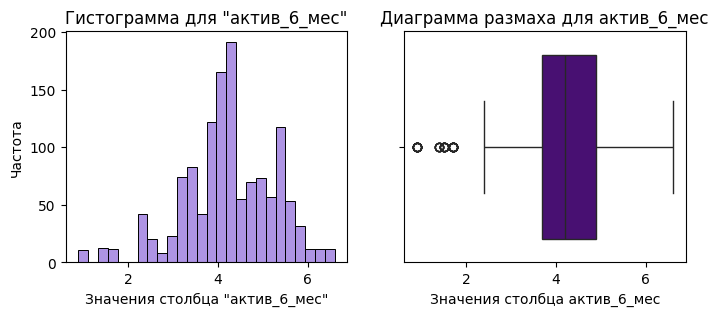

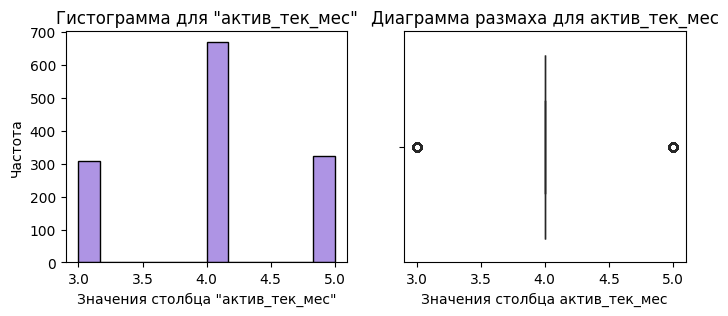

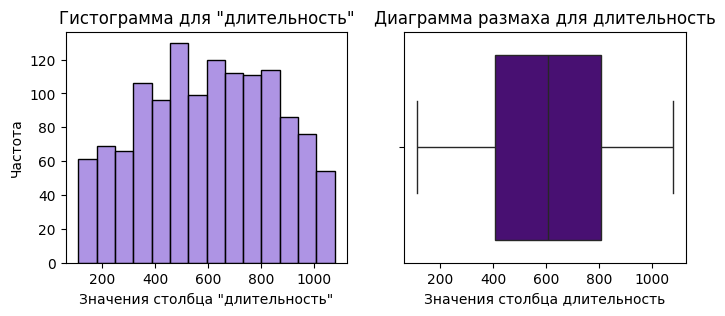

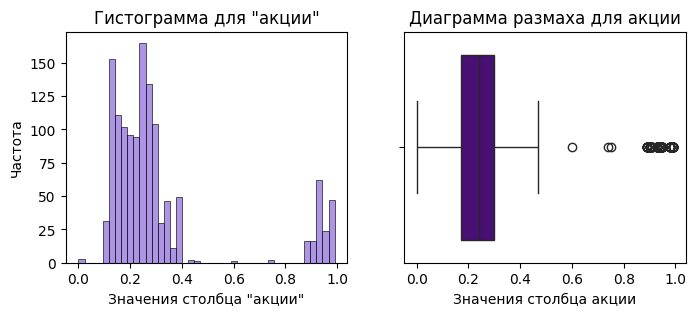

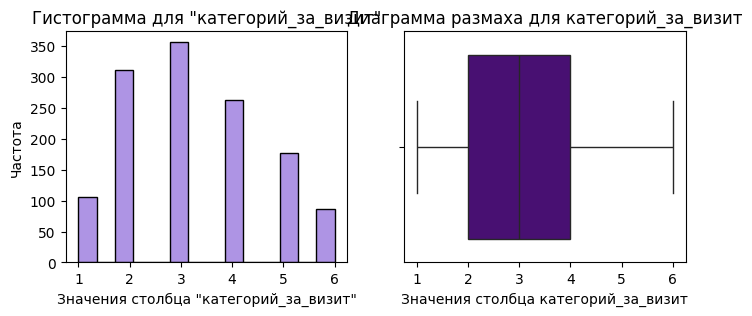

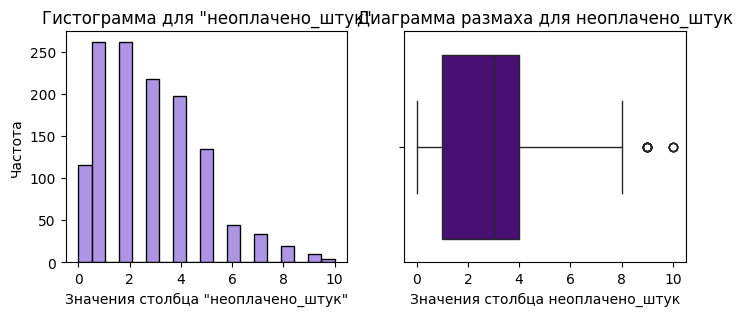

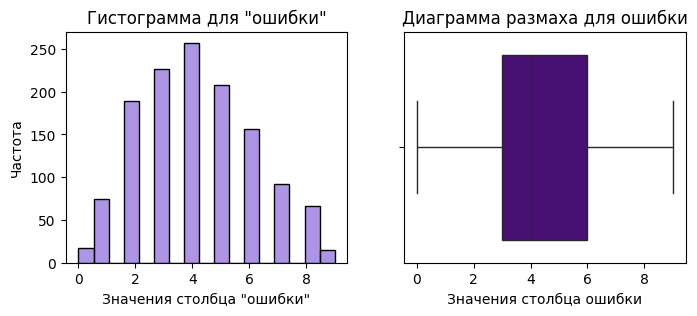

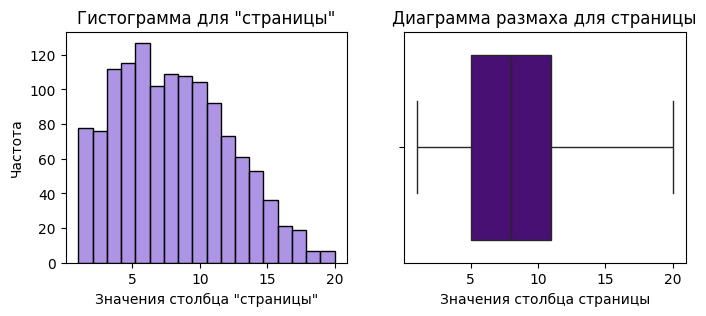

In [14]:
#построение распределений количественных признаков датасета market
for name in num_col_market:
    hist_box(market, name)

* признак `актив_6_мес` в целом распределен нормально, есть несколько слишком малых значений. Надо иметь это ввиду, возможно придется их удалить;
* признак `актив_тек_мес` можно сделать категориальным признаком с 3-мя категориями;
* признак `длительность` в целом распределен равномерно на всём диапазоне значений;
* признак `акции` имеет бимодальное распределение - в области 0,2 и в области близкой к 1. Есть немалая доля покупателей, кто покупает только по акции! К ним нужно присмотреться повнимательней;
* признак `категорий_за_визит` имеет нормальное распределение, можно сделать категориальным признаком с 6 категориями;
* признак `неоплачено_штук` имеет слегка скорешенное влево распределение  - редко кто хранит в корзине больше 8 предметов - будет категориальным признаком с 11 категориями;
* признак `ошибки` распределен нормально - будет категориальным признаком с 10 категориями;
* признак `страницы` имеет слегка скошенное влево нормальное распределение.

### m_money

In [15]:
#создание списка количественных столбцов датасета m_money
num_col_m_money = ['выручка'] 

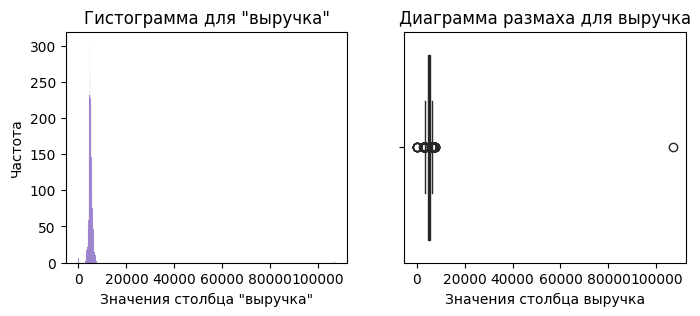

In [16]:
#построение распределений количественных признаков датасета m_money
for name in num_col_m_money:
    hist_box(m_money, name)

In [17]:
#нахождение выбросов
m_money.query('выручка > 20000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


Имеется одно аномально большое значение `выручки`. Это выручка за текущий месяц (который, как я полагаю, еще не закончился). Стоит это значение убрать. А также убрать данного пользователя из всех датасетов.

In [18]:
#удаление аномально большого значения выручки
m_money = m_money.query('выручка < 20000')

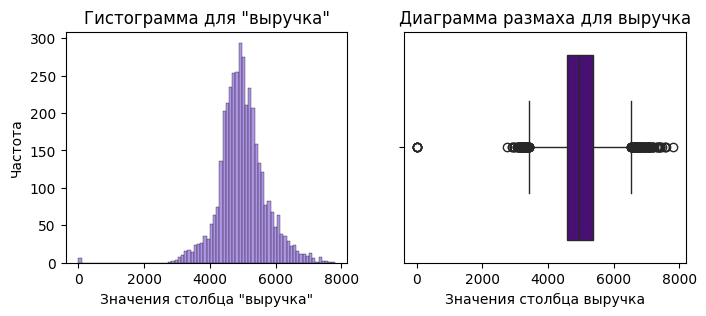

In [19]:
#построение распределений количественных признаков датасета m_money без выбросов
for name in num_col_m_money:
    hist_box(m_money, name)

Признак `выручка` распределен нормально, также имеются нулевые значения - это пользователи, которые не совершали покупок в указанные периоды. От них тоже придется "избавиться".

### time

In [20]:
#создание списка количественных столбцов датасета m_money
num_col_time = ['минуты'] 

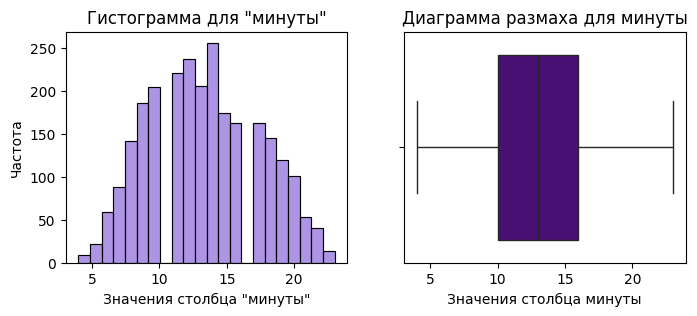

In [21]:
#построение распределений количественных признаков датасета time
for name in num_col_time:
    hist_box(time, name)

Признак `минуты` распределен нормально.

### money

In [22]:
#создание списка количественных столбцов датасета m_money
num_col_money = ['прибыль'] 

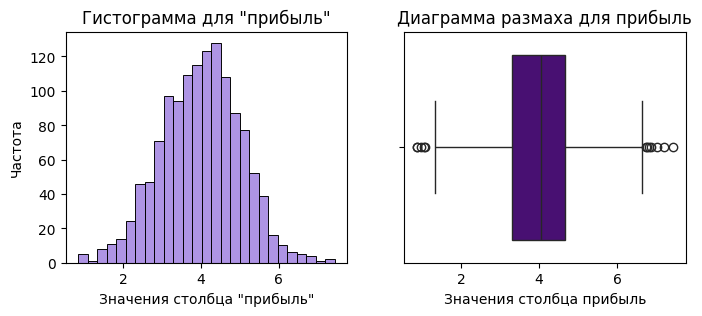

In [23]:
for name in num_col_money:
    hist_box(money, name)

Признак `прибыль` распределен нормально.

## Категориальные признаки

In [24]:
#создание функции для построения круговой диаграммы для категориальных признаков

def pie_graph(dataset, column, name, n, i):
    plt.subplot(1, n, i)
    plt.title(column)
    plt.pie(x=dataset.groupby(column)[name].count(),
            startangle=90,
            labeldistance=1.1, 
            wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
            autopct='%1.1f%%',
            labels=dataset.groupby(column)[name].count().index, 
            colors=sns.color_palette('BuPu_r'))

### market

In [25]:
#создание списка категориальных признаков датасета market
cat_col_market = ['активность', 'сервис', 'рассылка', 'категория']

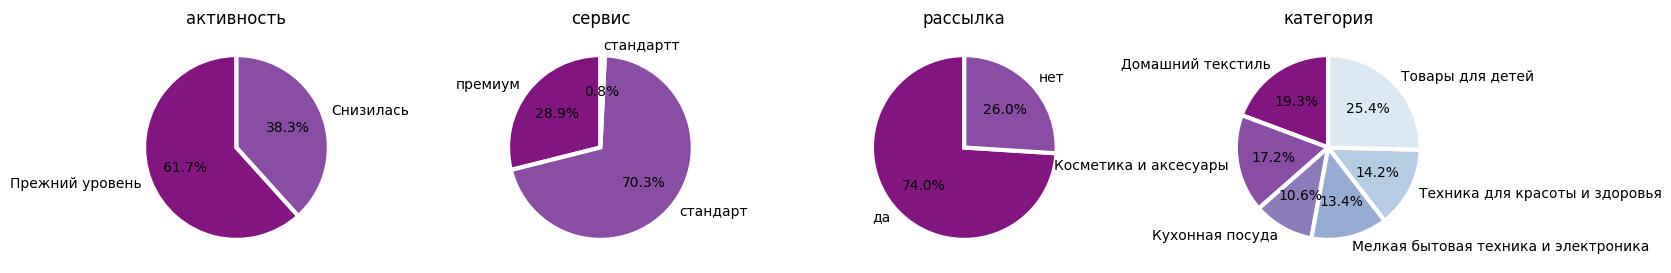

In [26]:
#круговые диаграммы для датасета market
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_market:
    pie_graph(market, name, 'id', len(cat_col_market), i)
    i += 1

* у признака `сервис` есть странная категория "стандартт", которую нужно переделать в "стандарт";
* других необычных значений в признаках не наблюдается (помимо "аксесуары" конечно :)));
* также стоит отметить несбалансированность признаков.

In [27]:
#замена значения в признаке "сервис"
market['сервис'] = market['сервис'].replace('стандартт', 'стандарт')

### m_money

In [28]:
#создание списка категориальных признаков датасета m_money
cat_col_m_money = ['период']

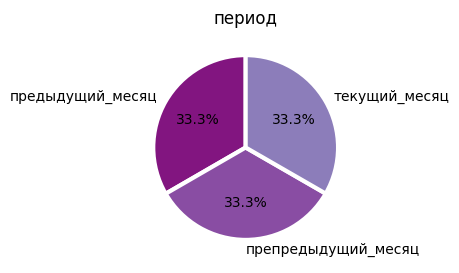

In [29]:
#круговые диаграммы для датасета m_money
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_m_money:
    pie_graph(m_money, name, 'id', len(cat_col_m_money), i)
    i += 1

Признак распределен равномерно, странных значений категории нет.

### time

In [30]:
#создание списка категориальных признаков датасета time
cat_col_time = ['период']

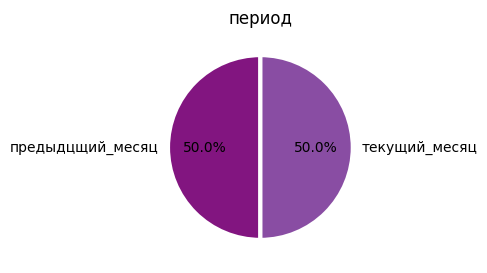

In [31]:
#круговые диаграммы для датасета time
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_time:
    pie_graph(time, name, 'id',len(cat_col_time), i)
    i += 1

Признак распределен равномерно, однако надо заменить значение "предыдцщий_месяц" на "предыдущий_месяц" для последующего объединения таблиц по этому столбцу.

In [32]:
#замена значения в признаке "период"
time['период'] = time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

## Выбор покупателей, активных в последние 3 месяца

In [33]:
#выбор пользователей, не принесших выручку в течение последних 3 месяцов
m_money.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Пользователей, которые проявляли активность в течение менее 3-х месяцев, всего трое. Их нужно убрать из датасетов.

In [34]:
#выбор активных покупателей    
market = market.query('id != [215348, 215357, 215359, 215380]')
m_money = m_money.query('id != [215348, 215357, 215359, 215380]')
time = time.query('id != [215348, 215357, 215359, 215380]')
money = money.query('id != [215348, 215357, 215359, 215380]')

print('market' ,market.shape[0])
print('m_money', m_money.shape[0])
print('time', time.shape[0])
print('money', money.shape[0])

market 1296
m_money 3888
time 2592
money 1296


# Объединение таблиц

## Объединение market с m_money

In [35]:
#список категорий периодов для создания новых столбцов
m_money_period = ['препредыдущий_месяц', 
                  'предыдущий_месяц', 
                  'текущий_месяц'] 

#добавление новых столбцов
for name in m_money_period:
    market = market.merge(m_money.query('период == @name'), 
                          on='id', 
                          how='left', 
                          suffixes=('_препред', '_пред'))

In [36]:
#удаление ненужных столбцов
market = market.drop(labels=['период_препред', 
                             'период_пред', 
                             'период'], axis=1)

#переименование столбца для единого стиля
market = market.rename(columns={'выручка':'выручка_тек'})

#проверка проведенных действий
market.head()

,id,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_препред,выручка_пред,выручка_тек
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5


## Объединение market с time

In [37]:
#список категорий периодов для создания новых столбцов
time_period = ['предыдущий_месяц', 
               'текущий_месяц'] 

#добавление новых столбцов
for name in time_period:
    market = market.merge(time.query('период == @name'), 
                          on='id', 
                          how='left', 
                          suffixes=('_пред', '_тек'))

In [38]:
#удаление ненужных столбцов
market = market.drop(labels=['период_пред', 'период_тек'], axis=1)
#проверка проведенных действий
market.head()

,id,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_препред,выручка_пред,выручка_тек,минуты_пред,минуты_тек
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


Таблицы объединены. 

## Исследовательский анализ объединенной таблицы для двух категорий пользователей

In [39]:
#создание функции для построения гистограммы диаграммы размаха для количественных признаков

def hist_box_graph_1(dataset, column):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data=dataset, x=column, hue='активность', palette='BuPu')
    plt.xlabel(f'Значение параметра "{column}"')
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    plt.title(f'Диаграмма размаха для "{column}"')
    sns.boxplot(x='активность', y=column, data=dataset, palette='BuPu');
    plt.ylabel(f'Значение параметра "{column}"')

In [40]:
#создание списка количественных столбцов датасета market
num_col_market = ['актив_6_мес', 
                  'актив_тек_мес', 
                  'длительность', 
                  'акции',
                  'категорий_за_визит',
                  'неоплачено_штук', 
                  'ошибки', 
                  'страницы', 
                  'выручка_препред', 
                  'выручка_пред', 
                  'выручка_тек', 
                  'минуты_пред', 
                  'минуты_тек']

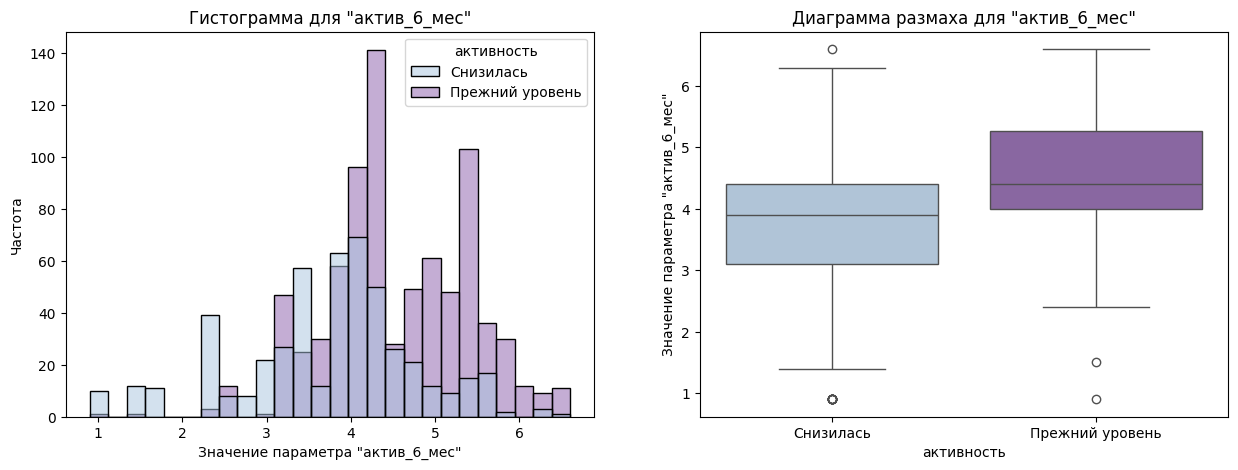

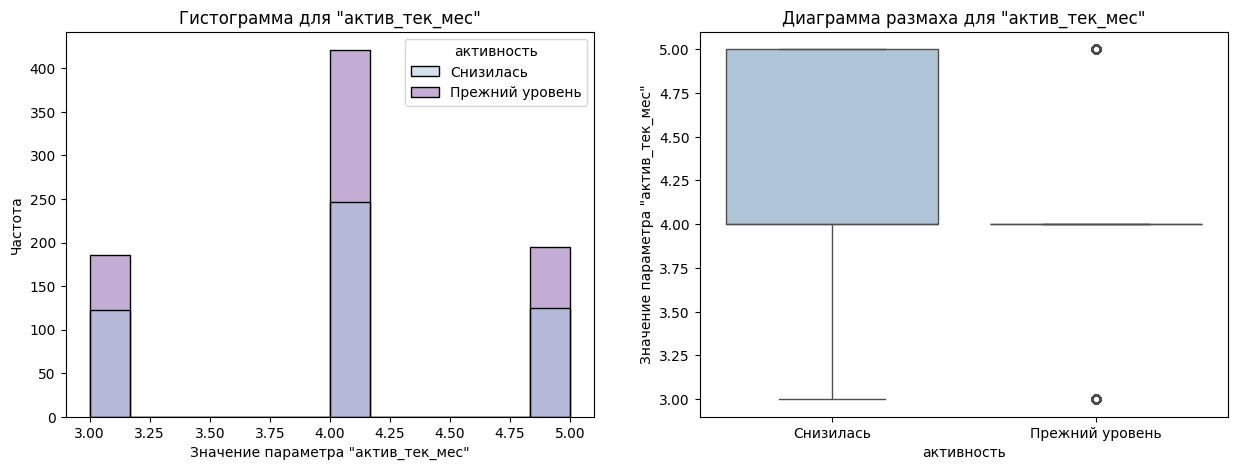

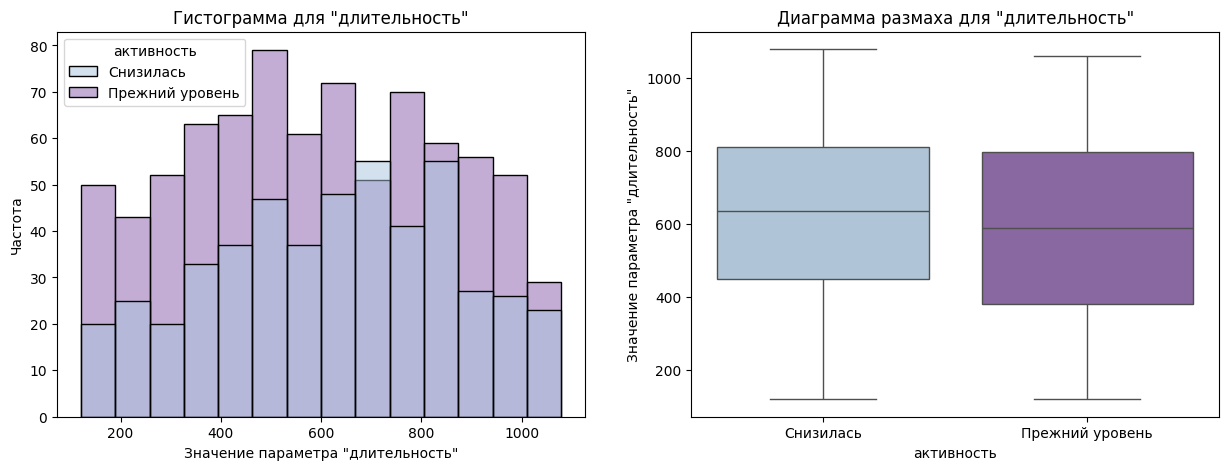

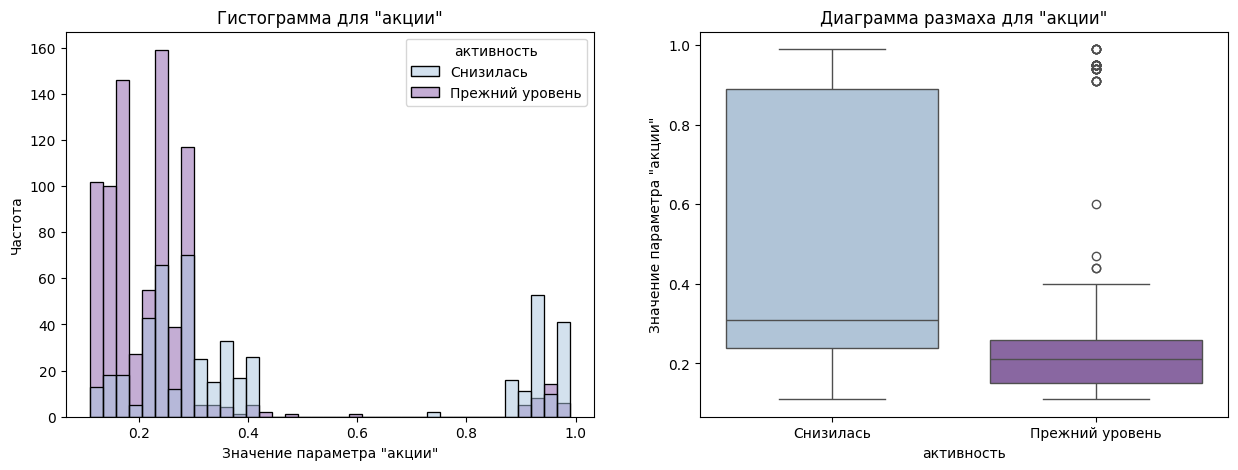

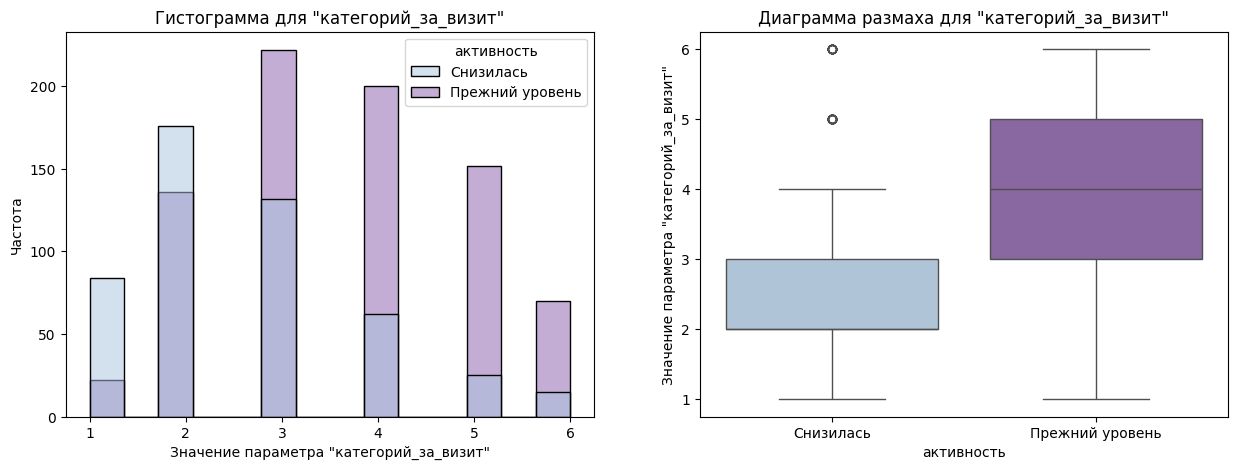

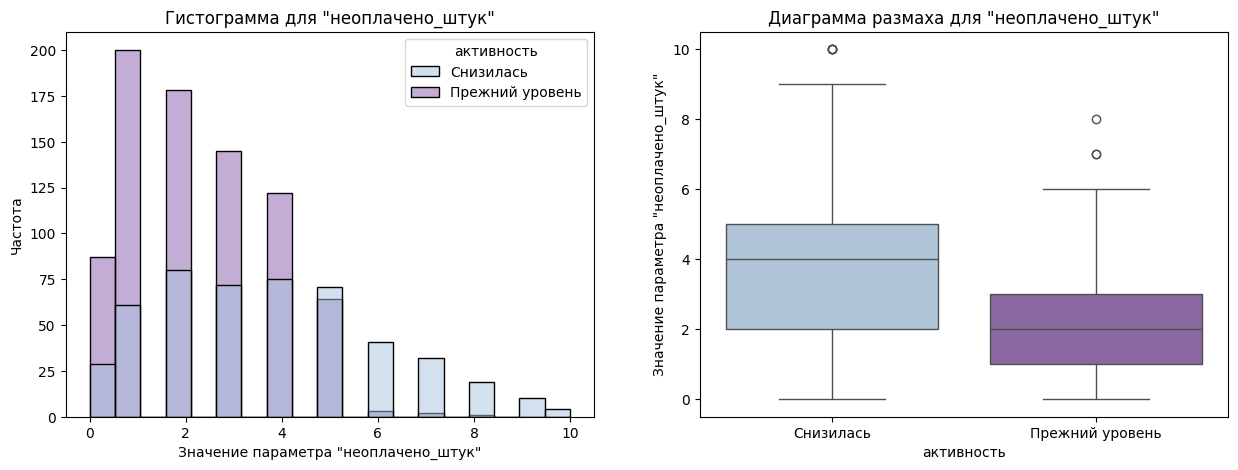

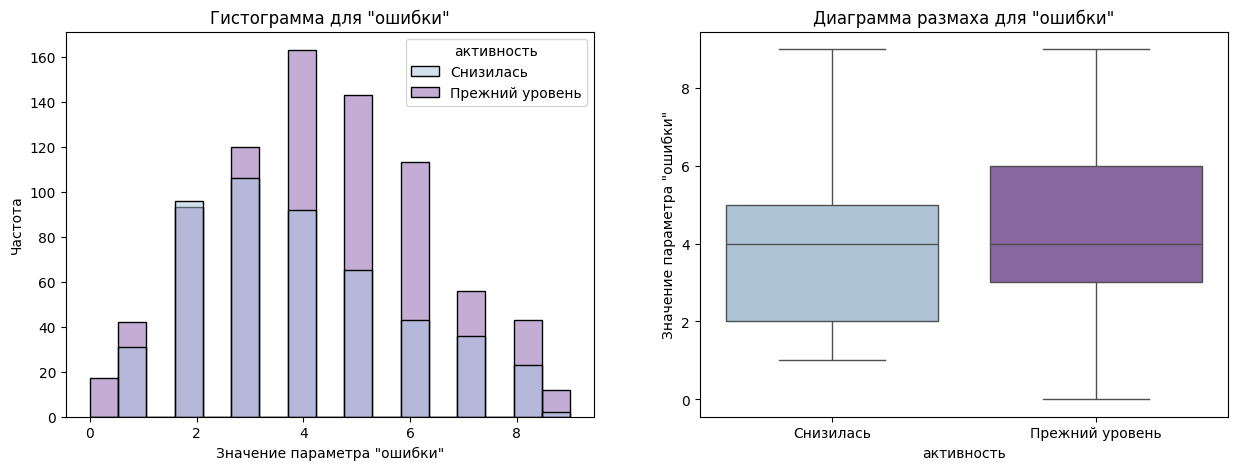

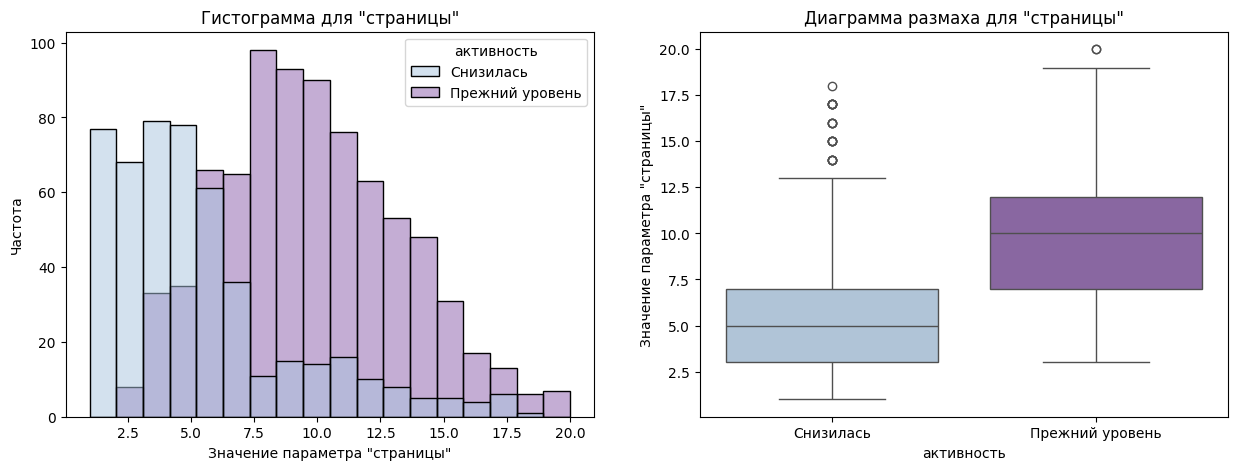

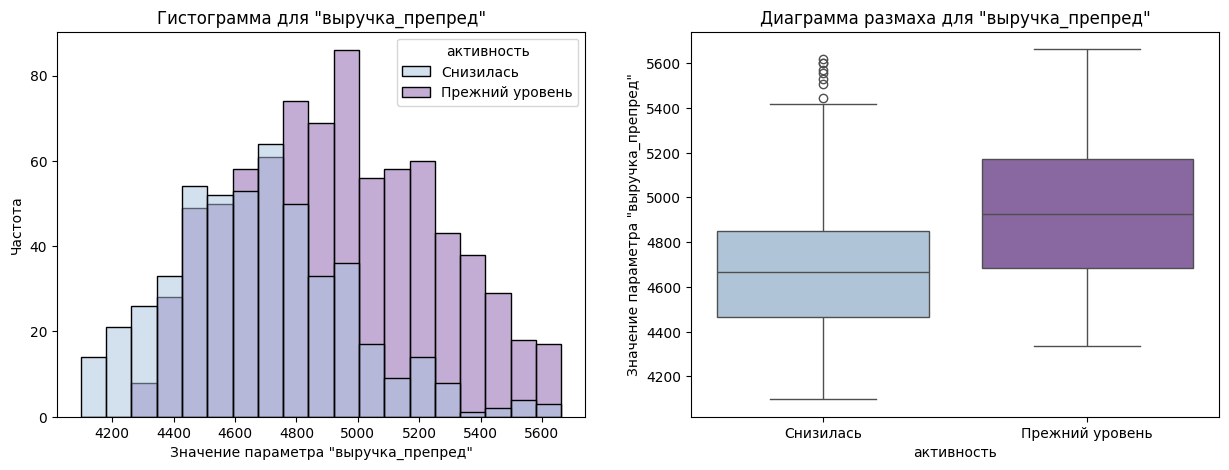

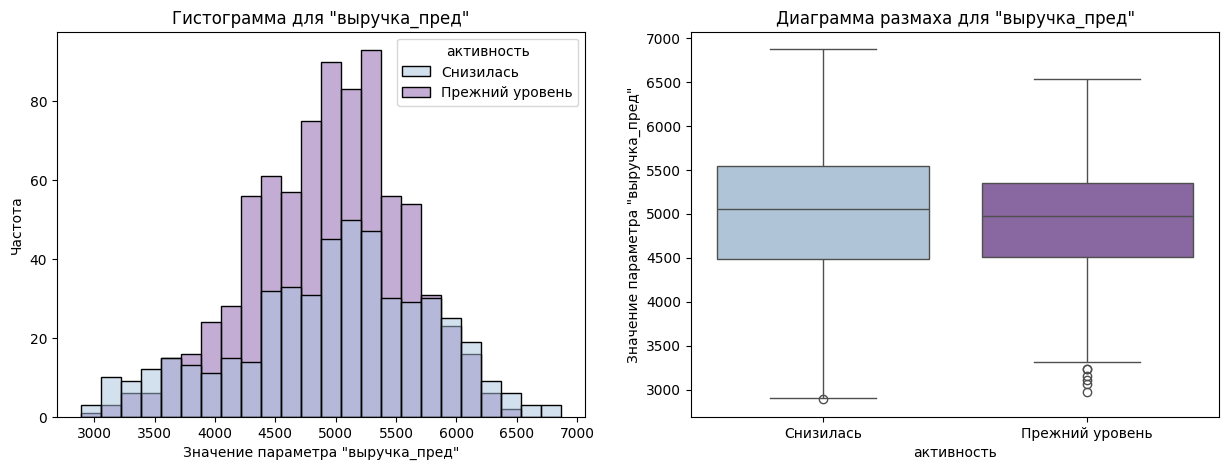

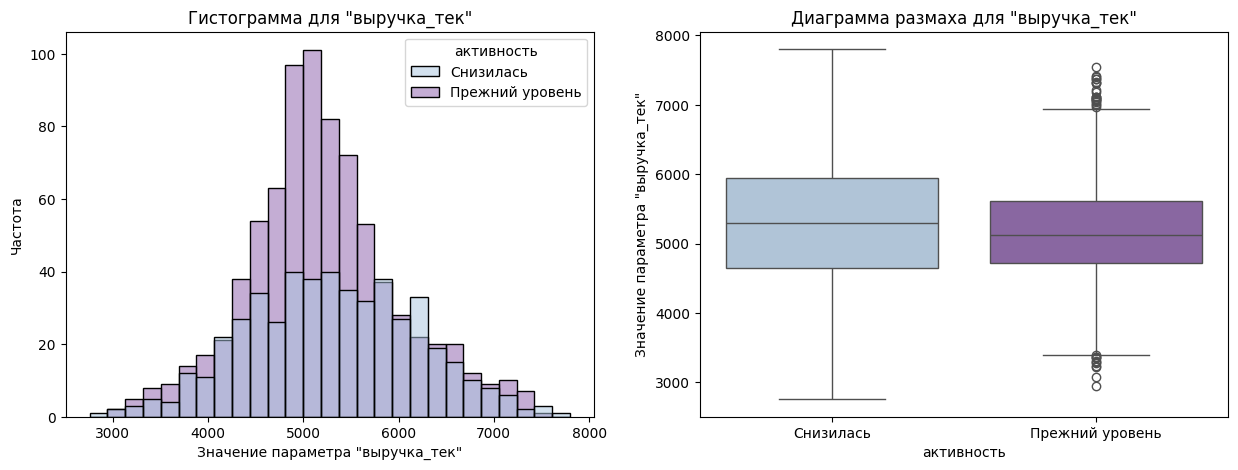

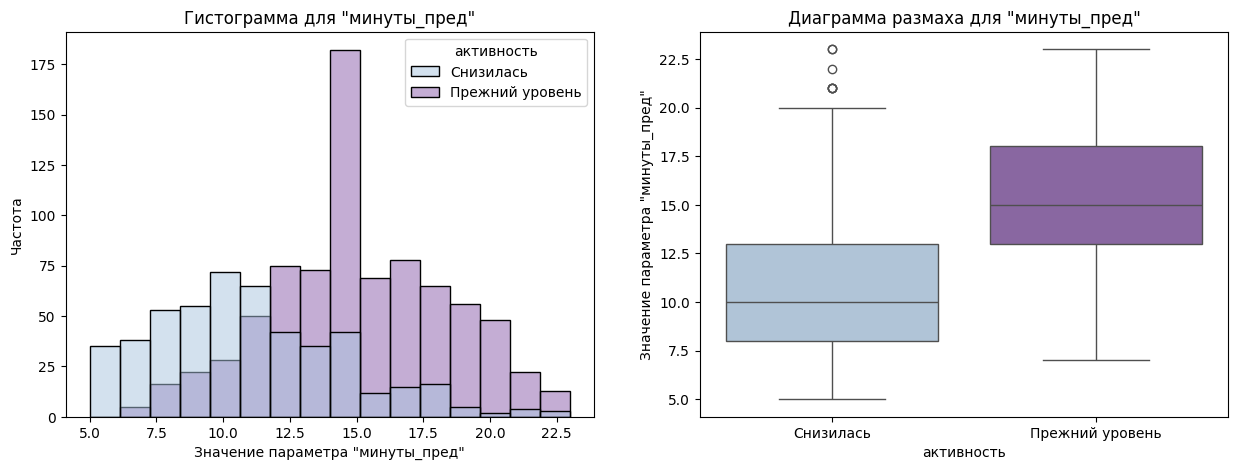

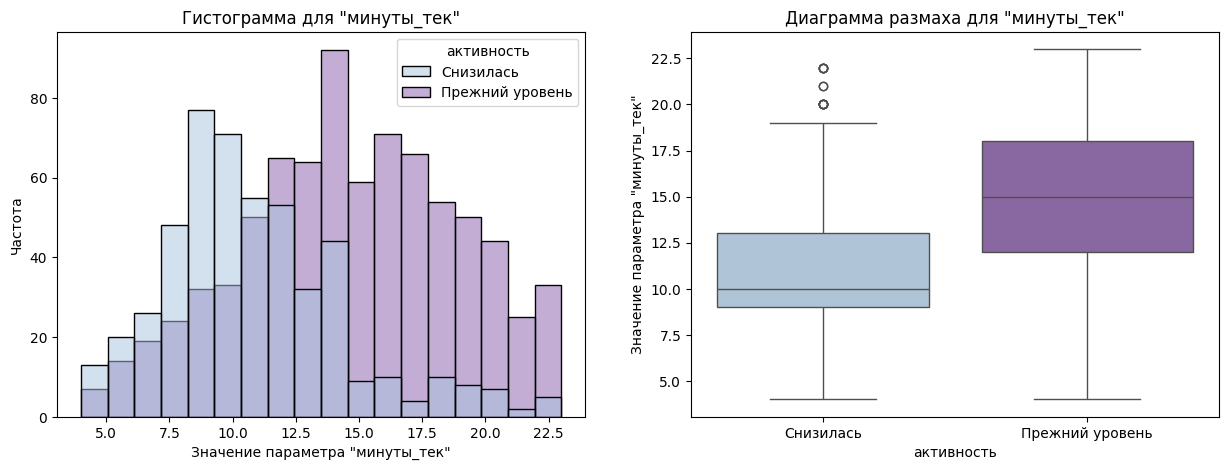

In [41]:
for name in num_col_market:
    hist_box_graph_1(market, name)

Из полученных графиков можно заметить, что распределение таких признаков как `актив_6_мес`, `aкции`, `категорий_за_визит`, `неоплачено_штук`, `страницы`, `выручка_препред`, `минуты_пред` и `минуты_тек` сильно отличаются для покупателей, у которых не снизилась покупательская активность и у которых снизилась. 
- признаки `актив_6_мес`, `категорий_за_визит`, `страницы`, `выручка_препред`, `минуты_пред` и `минуты_тек` в среднем ниже у покупателей со сниженной активностью, чем у покупателей с прежним уровнем активности;
- признаки `акции`, `неоплачено_штук` у покупателей со сниженной активностью в среднем выше , чем у покупателей с прежним уровнем активности.

In [42]:
#создание функции для построения круговой диаграммы для категориальных признаков

def pie_graph_1(dataset, column):
    plt.figure(figsize=(15,3))
    plt.subplot(1, 2, 1)
    plt.title(f'Признак "{column}"\n Покупательная активность - Снизилась')
    plt.pie(x=dataset[dataset['активность']=='Снизилась'].groupby(column)['id'].count(),
            startangle=90,
            labeldistance=1.1, 
            wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
            autopct='%1.1f%%',
            labels=dataset.groupby(column)[name].count().index, 
            colors=sns.color_palette('BuPu_r'))
    plt.subplot(1, 2, 2)
    plt.title(f'Признак "{column}"\n Покупательная активность - Прежний уровень')
    plt.pie(x=dataset[dataset['активность']!='Снизилась'].groupby(column)['id'].count(),
            startangle=90,
            labeldistance=1.1, 
            wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
            autopct='%1.1f%%',
            labels=dataset.groupby(column)[name].count().index, 
            colors=sns.color_palette('BuPu_r'))

In [43]:
#создание списка категориальных признаков датасета market
cat_col_market = ['сервис', 'рассылка', 'категория']

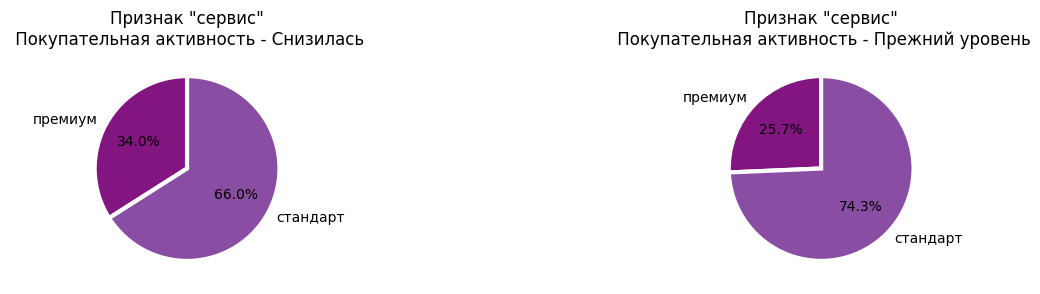

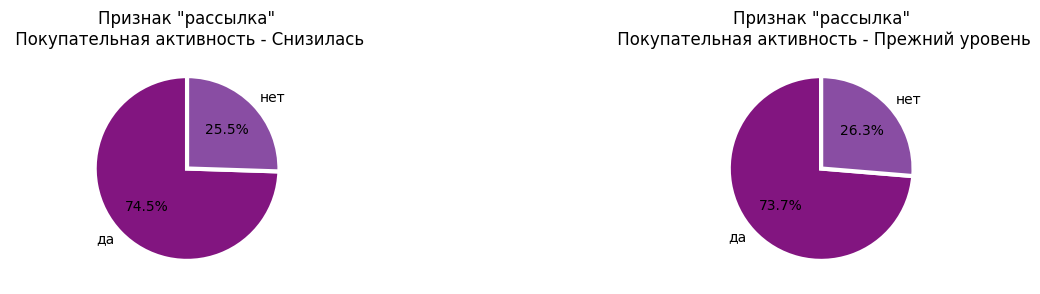

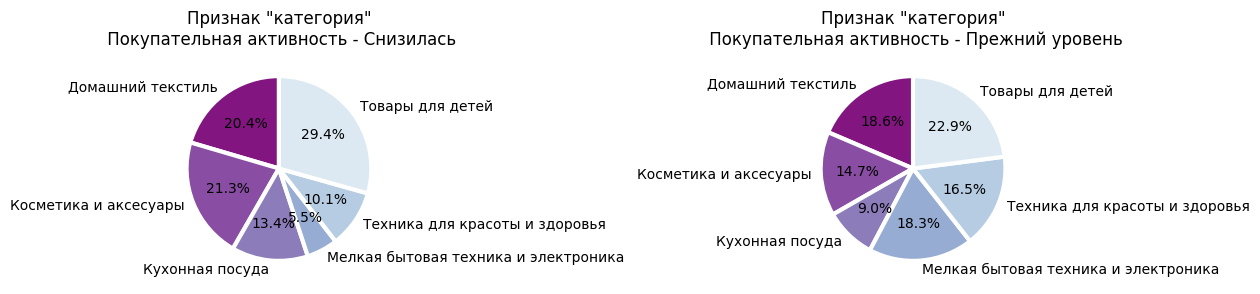

In [44]:
for name in cat_col_market:
    pie_graph_1(market, name)

Я бы сказала, что в разрезе целевого признака критических различий в значениях категориальных признаков нет.

# Корреляционный анализ

Поскольку в разделе "Исследовательского анализа" было показано, что количественные признаки распределены нормально, то для анализа корреляции мы можем использовать коэффциент корреляции Пирсона.

In [45]:
market.corr(numeric_only=True).style.background_gradient('BuPu')

,id,актив_6_мес,актив_тек_мес,длительность,акции,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_препред,выручка_пред,выручка_тек,минуты_пред,минуты_тек
id,1.000000,0.353950,-0.006226,-0.060275,-0.324270,0.271445,-0.294031,0.085184,0.499220,0.348417,-0.053761,-0.086727,0.480170,0.419595
актив_6_мес,0.353950,1.000000,0.058673,-0.038987,-0.239086,0.203207,-0.165317,0.034321,0.315082,0.243668,0.019636,0.013102,0.288165,0.222769
актив_тек_мес,-0.006226,0.058673,1.000000,-0.134008,-0.005567,-0.023907,0.054996,0.087951,0.005226,-0.042650,-0.033851,-0.016675,0.011083,-0.066597
длительность,-0.060275,-0.038987,-0.134008,1.000000,0.011925,-0.054592,-0.092571,0.112265,-0.039512,-0.050299,0.009961,0.016016,-0.122119,0.092488
акции,-0.324270,-0.239086,-0.005567,0.011925,1.000000,-0.170622,0.192280,-0.024624,-0.307173,-0.202596,-0.004928,0.014883,-0.271198,-0.218196
категорий_за_визит,0.271445,0.203207,-0.023907,-0.054592,-0.170622,1.000000,-0.274548,0.007010,0.240046,0.140861,-0.039468,-0.074118,0.135407,0.225666
неоплачено_штук,-0.294031,-0.165317,0.054996,-0.092571,0.192280,-0.274548,1.000000,-0.092234,-0.194733,-0.262671,-0.005369,0.038232,-0.182840,-0.206882
ошибки,0.085184,0.034321,0.087951,0.112265,-0.024624,0.007010,-0.092234,1.000000,0.087633,0.076241,0.039864,0.031695,0.187245,0.074379
страницы,0.499220,0.315082,0.005226,-0.039512,-0.307173,0.240046,-0.194733,0.087633,1.000000,0.292924,-0.039802,-0.029258,0.425277,0.254507
выручка_препред,0.348417,0.243668,-0.042650,-0.050299,-0.202596,0.140861,-0.262671,0.076241,0.292924,1.000000,0.327828,0.121678,0.347538,0.299646


Наблюдается высокая корреляция между выручками за предыдущий и текущий месяцы. Возможно стоит объединить эти данные в один столбец. 

In [46]:
market['выручка_пред_тек'] = market['выручка_пред'] + market['выручка_тек']
market.corr(numeric_only=True).style.background_gradient('BuPu')

,id,актив_6_мес,актив_тек_мес,длительность,акции,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_препред,выручка_пред,выручка_тек,минуты_пред,минуты_тек,выручка_пред_тек
id,1.000000,0.353950,-0.006226,-0.060275,-0.324270,0.271445,-0.294031,0.085184,0.499220,0.348417,-0.053761,-0.086727,0.480170,0.419595,-0.074722
актив_6_мес,0.353950,1.000000,0.058673,-0.038987,-0.239086,0.203207,-0.165317,0.034321,0.315082,0.243668,0.019636,0.013102,0.288165,0.222769,0.016768
актив_тек_мес,-0.006226,0.058673,1.000000,-0.134008,-0.005567,-0.023907,0.054996,0.087951,0.005226,-0.042650,-0.033851,-0.016675,0.011083,-0.066597,-0.025557
длительность,-0.060275,-0.038987,-0.134008,1.000000,0.011925,-0.054592,-0.092571,0.112265,-0.039512,-0.050299,0.009961,0.016016,-0.122119,0.092488,0.013815
акции,-0.324270,-0.239086,-0.005567,0.011925,1.000000,-0.170622,0.192280,-0.024624,-0.307173,-0.202596,-0.004928,0.014883,-0.271198,-0.218196,0.006087
категорий_за_визит,0.271445,0.203207,-0.023907,-0.054592,-0.170622,1.000000,-0.274548,0.007010,0.240046,0.140861,-0.039468,-0.074118,0.135407,0.225666,-0.060776
неоплачено_штук,-0.294031,-0.165317,0.054996,-0.092571,0.192280,-0.274548,1.000000,-0.092234,-0.194733,-0.262671,-0.005369,0.038232,-0.182840,-0.206882,0.019106
ошибки,0.085184,0.034321,0.087951,0.112265,-0.024624,0.007010,-0.092234,1.000000,0.087633,0.076241,0.039864,0.031695,0.187245,0.074379,0.036929
страницы,0.499220,0.315082,0.005226,-0.039512,-0.307173,0.240046,-0.194733,0.087633,1.000000,0.292924,-0.039802,-0.029258,0.425277,0.254507,-0.035519
выручка_препред,0.348417,0.243668,-0.042650,-0.050299,-0.202596,0.140861,-0.262671,0.076241,0.292924,1.000000,0.327828,0.121678,0.347538,0.299646,0.224954


У полученного признака есть только корреляция с признаками, из которых он получен. С другими сильной корреляции нет - от мульколлениарности удалось избавиться.

# Выбор лучшей модели МО

## Подготовка данных и пайплайнов

In [47]:
#разбиение на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['активность','выручка_пред', 'выручка_тек', 'id'], axis=1),
    market['активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market['активность'])

In [48]:
#кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [49]:
#создание списков количественных и категориальных признаков

#категориальные
cat_col = ['сервис', 
           'рассылка', 
           'категория'] 

#количественные
num_col = ['актив_6_мес', 
           'длительность', 
           'акции',
           'страницы', 
           'выручка_препред', 
           'выручка_пред_тек', 
           'минуты_пред', 
           'минуты_тек', 
           'актив_тек_мес',
           'категорий_за_визит',
           'неоплачено_штук', 
           'ошибки'] 

In [50]:
# Pipeline для кодирования категориальных признаков
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent')), 
        ('ohe', 
         OneHotEncoder(drop='first', 
                       handle_unknown='error', 
                       sparse=False))
    ]
)

In [51]:
# Pipeline для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [52]:
# Итоговый Pipeline: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [53]:
#Параметры для передачи GridSearchCV для поиска оптимальной модели 
#с разными Scaler и Encoder

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE),
               KNeighborsClassifier(),
               SVC(random_state=RANDOM_STATE),
               LogisticRegression(random_state=RANDOM_STATE)]
}

In [54]:
#Параметры для передачи GridSearchCV для поиска оптимальной модели 
#с разными Scaler и Encoder и перебором гиперпараметров

param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

## Поиск оптимальной модели без перебора гиперпараметров

In [55]:
#поиск оптимальной модели без перебора гиперпараметров
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)

#обучение модели на тренировочной выборке
grid.fit(X_train, y_train)

#вывод лучшей модели
print('Лучшая модель и её параметры:\n\n', grid.best_params_)

Лучшая модель и её параметры:

 {'models': SVC(random_state=42), 'preprocessor__num': StandardScaler()}


/home/ksenia/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ksenia/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

In [56]:
#вывод метрики лучшей модели
print('Метрика ROC-AUC для лучшей модели:\n', round(grid.best_score_, 4)) 

Метрика ROC-AUC для лучшей модели:
 0.9084


## Выбор оптимальной модели с перебором гиперпараметров

In [57]:
#поиск оптимальной модели с перебором гиперпараметров
grid_1 = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
)

#обучение модели на тренировочной выборке
grid_1.fit(X_train, y_train)

/home/ksenia/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ksenia/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         ['сервис',
                                                                          'рассылка',
                                                                          'категория']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['актив_6_мес',
                                                                          'длительность',
                                                                          'акции',
                                                                          '...
                          'models__max_depth': range(2, 11),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(random_state=42)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [58]:
print('Метрика ROC-AUC для лучшей модели:\n', round(grid_1.best_score_, 4)) 
print('\nЛучшая модель и её параметры:\n\n', grid_1.best_params_) 

Метрика ROC-AUC для лучшей модели:
 0.9084

Лучшая модель и её параметры:

 {'models': SVC(probability=True, random_state=42), 'preprocessor__num': StandardScaler()}


Лучшей моделью снова оказалась **SVC** с roc_auc = 0.9084. 

In [59]:
y_pred = grid_1.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred[:, 1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.9118


На тестовой выборке метрика получилась чуть выше, чем на тренировочной. 

# Анализ важности признаков

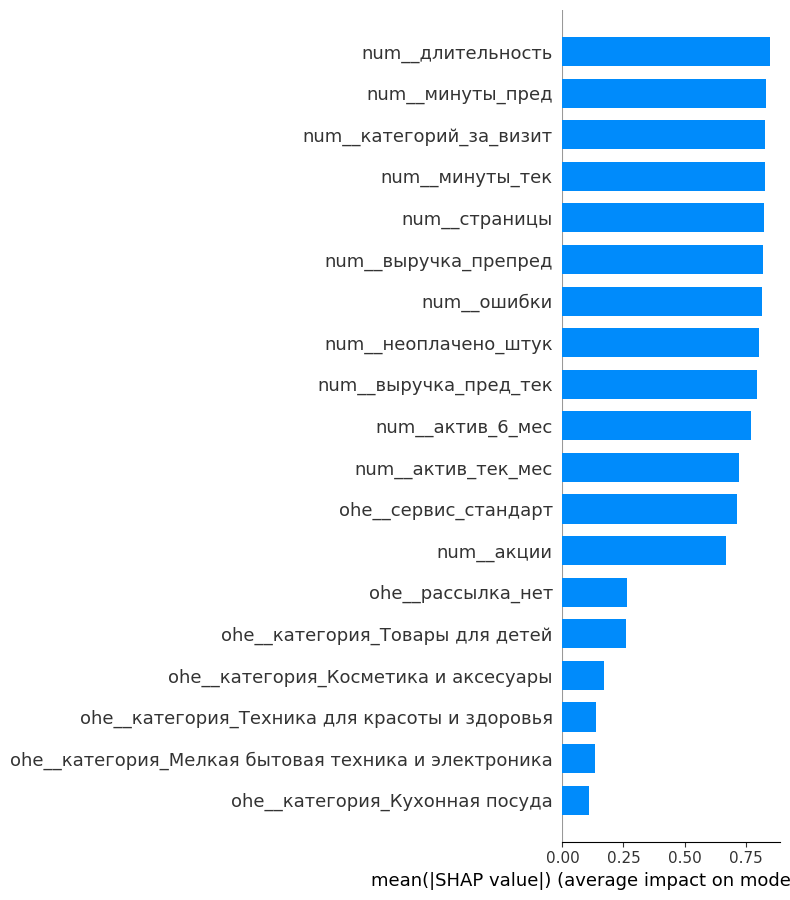

In [60]:
#поиск важных признаков
X_encoded_1 = grid_1.best_estimator_['preprocessor'].fit_transform(X_train)

model_1 = grid_1.best_estimator_['models'].fit(X_encoded_1, y_train)
explainer_1 = shap.PermutationExplainer(model_1, X_encoded_1)


labels_1 = grid_1.best_estimator_[:-1].get_feature_names_out()

shap.summary_plot(X_encoded_1, plot_type='bar', feature_names=labels_1) 

Наиболее важными признаками будут `длительность` (с момента регистрации пользователя), `минуты` - время, проводимое на сайте, `категории за визит`, `количество просмотренных страниц`. 
На самом деле тут много практически одинаковых по важности признаков - от `длительности` до `количества покупок по акциям`. По всем этим признакам можно попробовать разбить покупателей на сегменты. 

# Сегментация покупателей

In [61]:
#добавление к данным покупателей их 
#вероятности отношения к классу 1 (сниженный уровень активности)

X_test['вероятность'] = y_pred[:, 1]
data = X_test.sort_values(by='вероятность')
data.head()

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_препред,минуты_пред,минуты_тек,выручка_пред_тек,вероятность
485,премиум,да,4.9,3,888,0.14,Техника для красоты и здоровья,3,1,6,9,5268.0,15,18,9591.0,0.017306
885,стандарт,да,4.1,4,551,0.21,Мелкая бытовая техника и электроника,4,1,4,10,4607.0,17,13,10010.5,0.021020
695,премиум,да,3.9,4,572,0.14,Мелкая бытовая техника и электроника,4,2,2,6,5194.0,16,18,11958.5,0.021101
453,стандарт,нет,4.1,4,808,0.15,Мелкая бытовая техника и электроника,4,2,3,13,4691.0,12,16,8872.1,0.021571
1113,стандарт,да,4.9,4,739,0.17,Мелкая бытовая техника и электроника,5,1,4,4,5180.0,18,15,11423.1,0.022644


In [62]:
num_data = ['актив_6_мес', 
            'актив_тек_мес', 
            'длительность', 
            'акции', 
            'категорий_за_визит', 
            'неоплачено_штук', 
            'ошибки', 
            'страницы', 
            'выручка_препред', 
            'минуты_пред', 
            'минуты_тек', 
            'выручка_пред_тек']

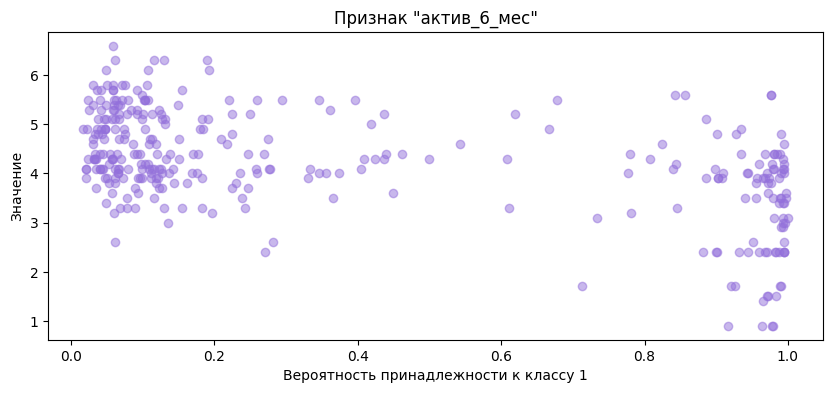

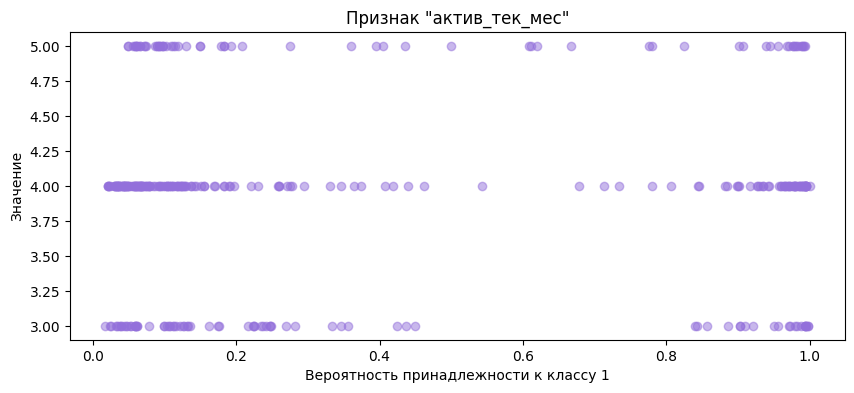

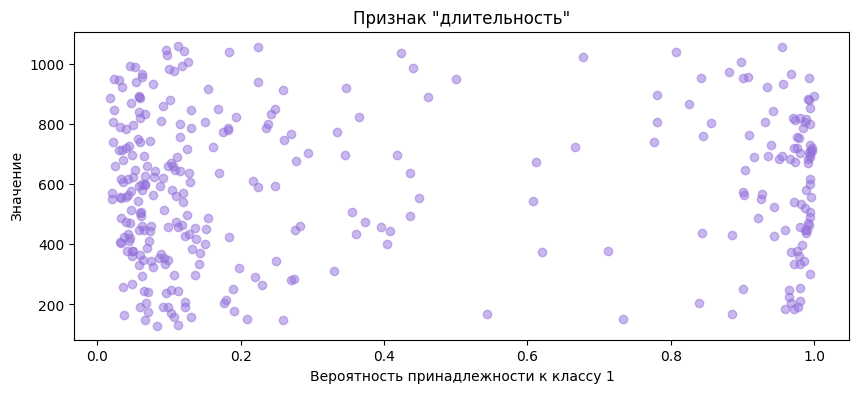

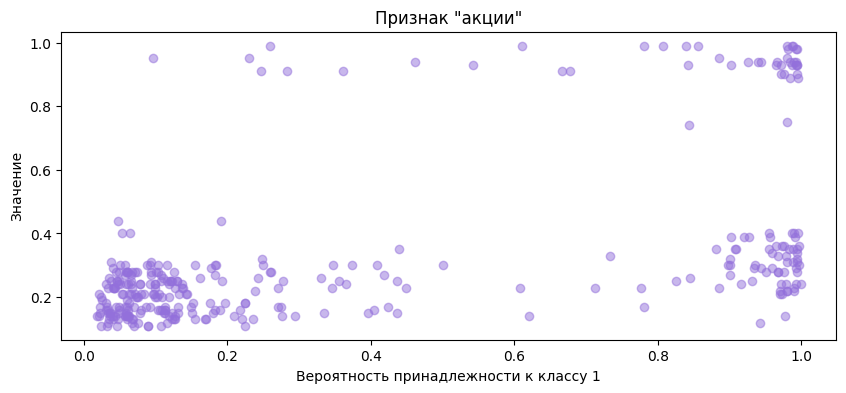

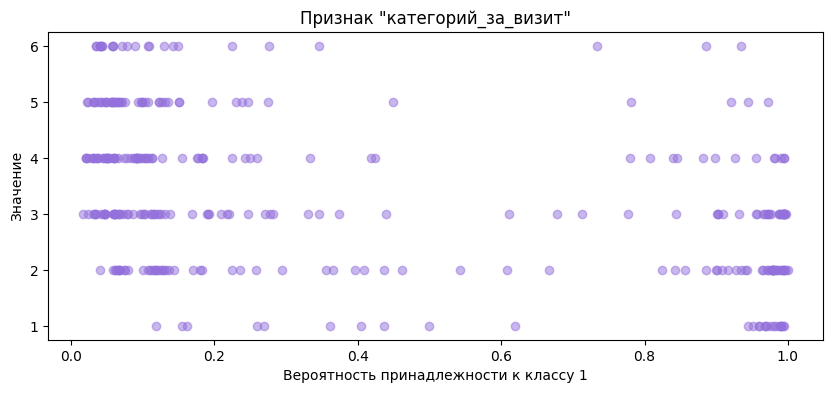

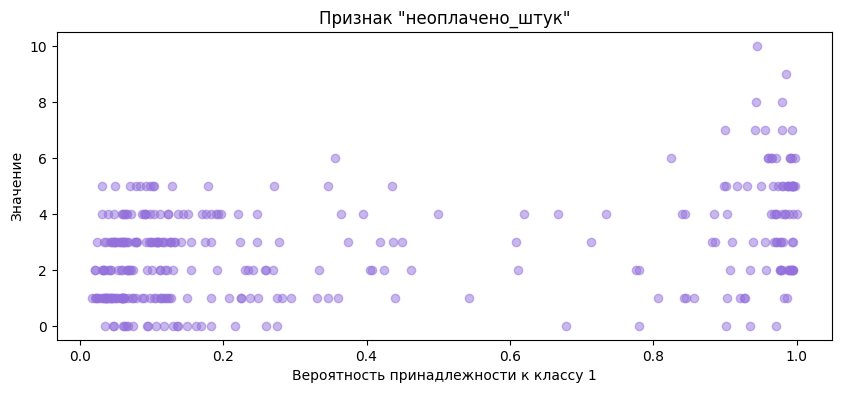

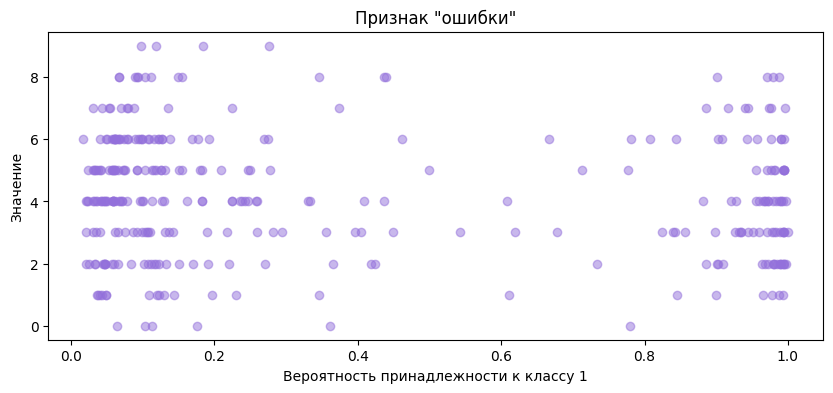

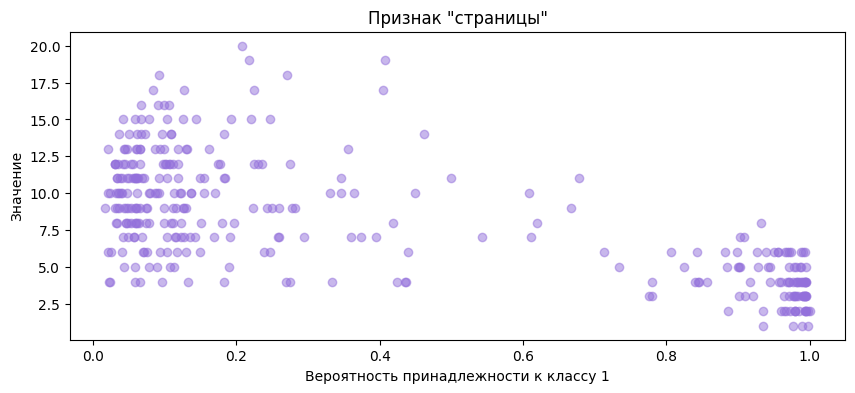

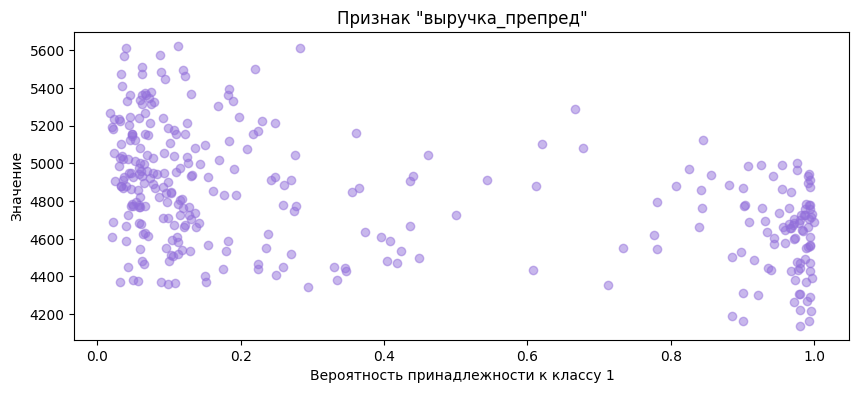

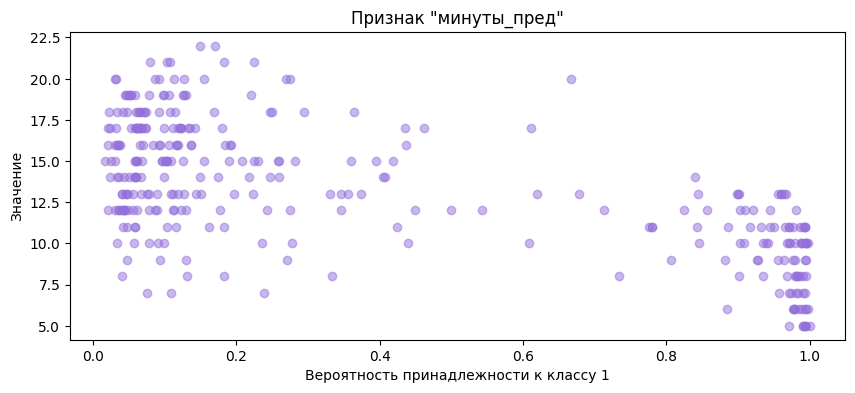

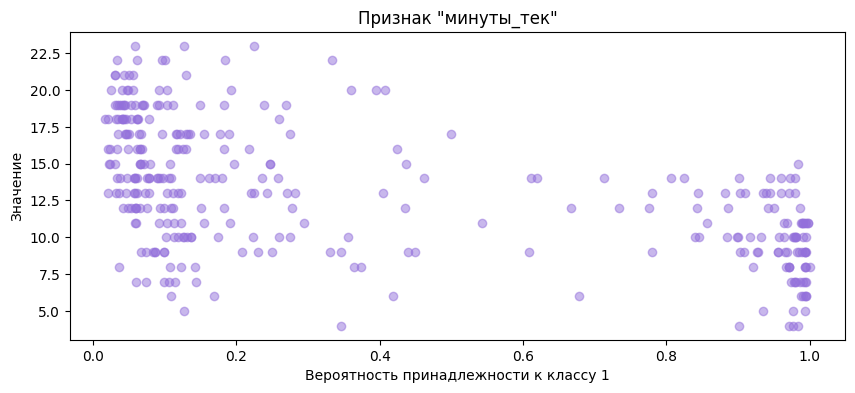

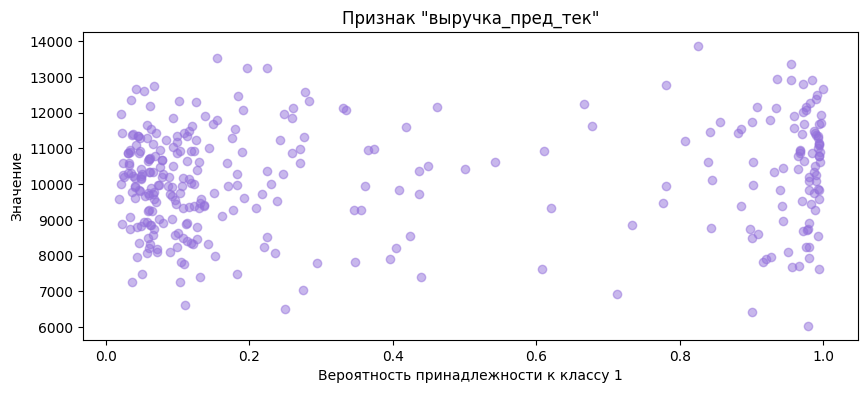

In [63]:
#построение scatter plot для распределения числовых 
#признаков в зависимости от вероятности принадлежности к классу

for name in num_data:
    plt.figure(figsize=(10, 4))
    plt.title(f'Признак "{name}"')
    plt.xlabel('Вероятность принадлежности к классу 1')
    plt.ylabel(f'Значение')
    plt.scatter(x=data['вероятность'], 
                y=data[name],
                alpha=0.5, 
                c='MediumPurple')

На основании приведенных графиков можно выделить следующие пороги значений признака для разделения покупателей на классы. В частности, покупатели со сниженной активностью имеют значения признака:
- "актив_6_мес" менее 3;
- "акции" выше 0.6;
- "категорий_за_визит" менее 3;
- "неоплачено_штук" более 5;
- "страницы" менее 7;
- "выручка_препред" ниже 5000;
- "минуты_пред" ниже 14;
- "минуты_тек" ниже 14. 

В остальных признаках сложно выделить пороги. 

Можно выделить сегмент покупателей, которые покупают во основном акционные товары, то есть со значениями признака "акции" более 0.6, поскольку активность таких покупателей снизилась на последнее время.

In [64]:
df = data.query('выручка_препред < 5000')

Рассмотрим распределение признаков для выбранного сегмента пользователей.

In [65]:
#списки количественных и категориальных признаков
num_df = ['актив_6_мес',          
          'актив_тек_мес', 
          'длительность',
          'категорий_за_визит',
          'акции', 
          'неоплачено_штук', 
          'ошибки', 
          'страницы', 
          'минуты_пред', 
          'минуты_тек', 
          'выручка_препред',
          'выручка_пред_тек']

cat_df = ['сервис', 'рассылка', 'категория']

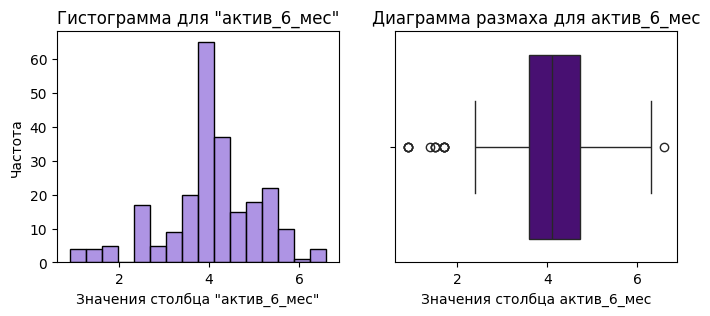

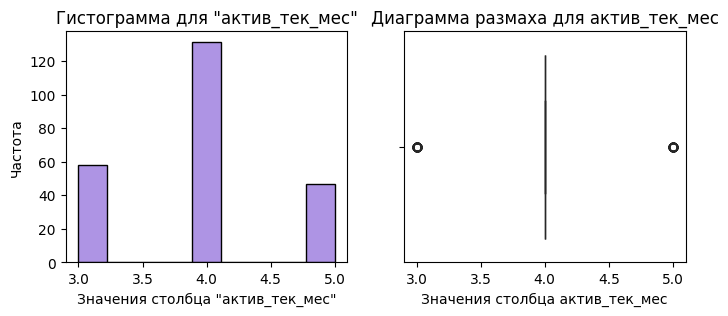

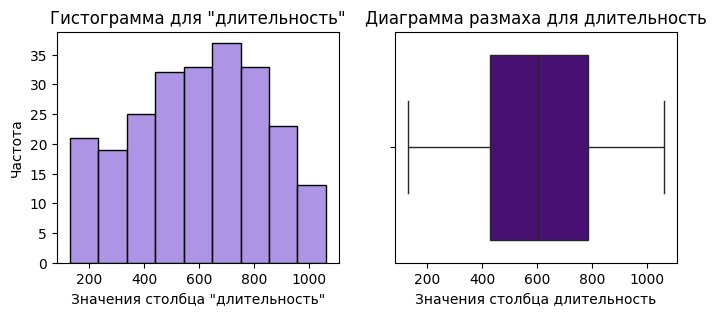

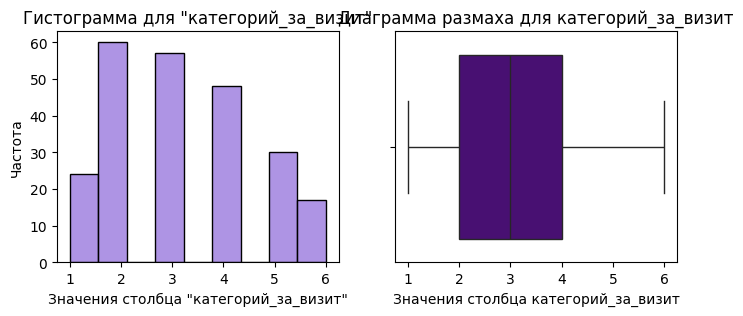

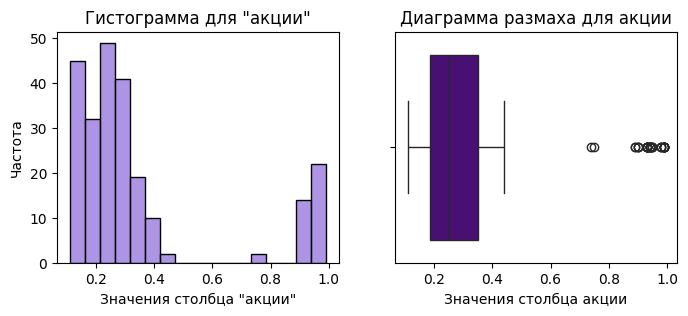

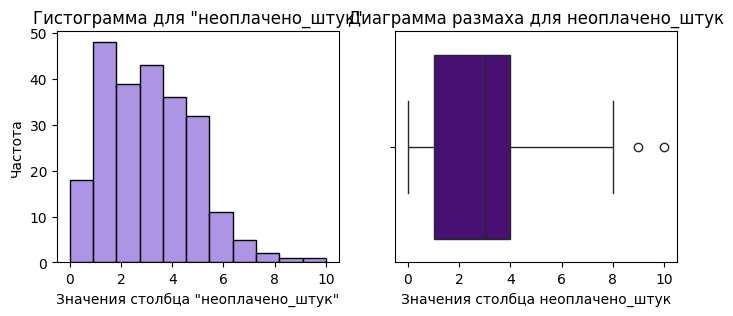

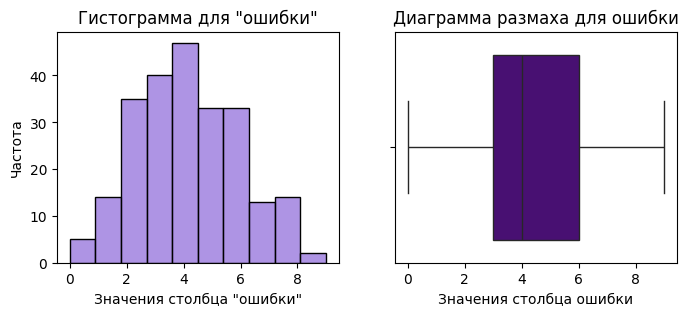

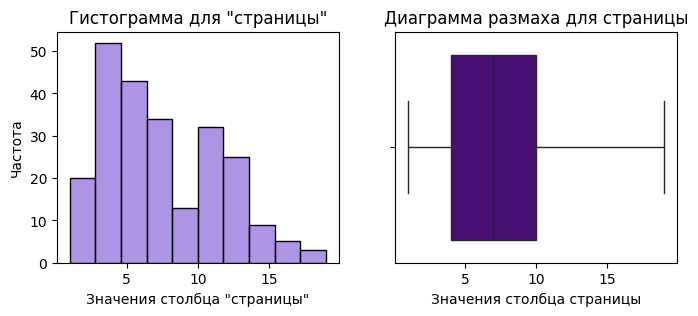

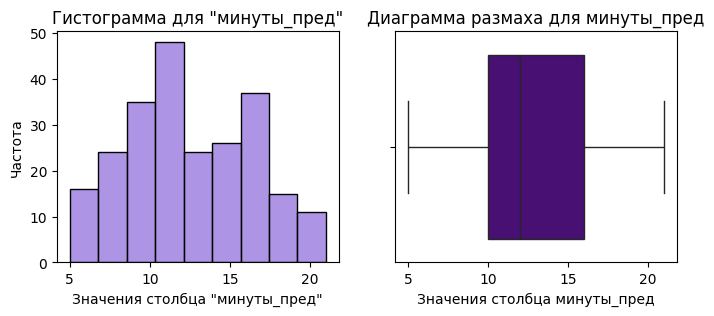

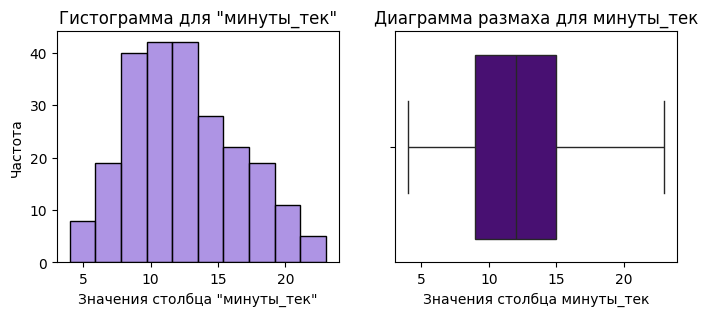

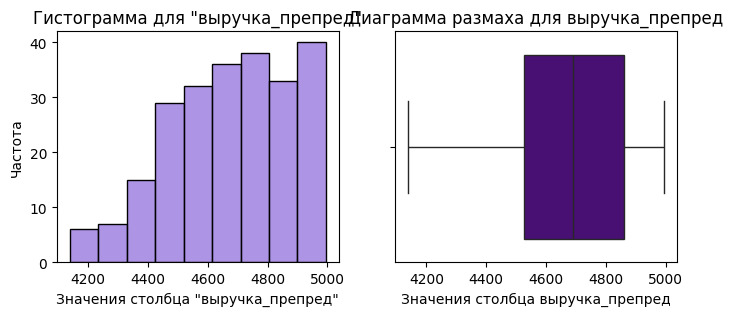

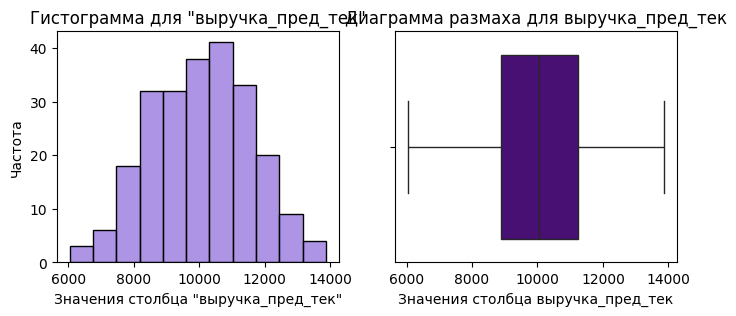

In [66]:
#построение распределений количественных признаков
for name in num_df:
    hist_box(df, name)

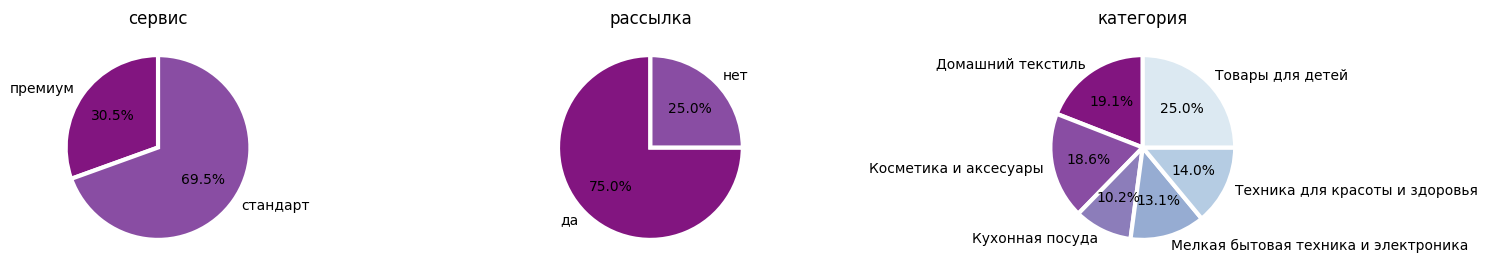

In [67]:
#построение распределений категориальных признаков

i = 1
plt.figure(figsize=(18,3))
for name in cat_df:
    pie_graph(df, name, 'актив_тек_мес',len(cat_df), i)
    i += 1

Данный сегмент покупателей в основном покупает товары для детей и домашний текстиль. 
Также большинство таких покупателей не покупает по акциям, хотя им приходят рассылка различных предложений. 

Возможно данной категории пользователей стоит разослать акции на товары для детей.

In [68]:
market = market.merge(money, 
                      on='id', 
                      how='left',)
market.head()

,id,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_препред,выручка_пред,выручка_тек,минуты_пред,минуты_тек,выручка_пред_тек,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,10187.6,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,10515.9,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,12768.4,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,11680.0,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,10127.0,3.95


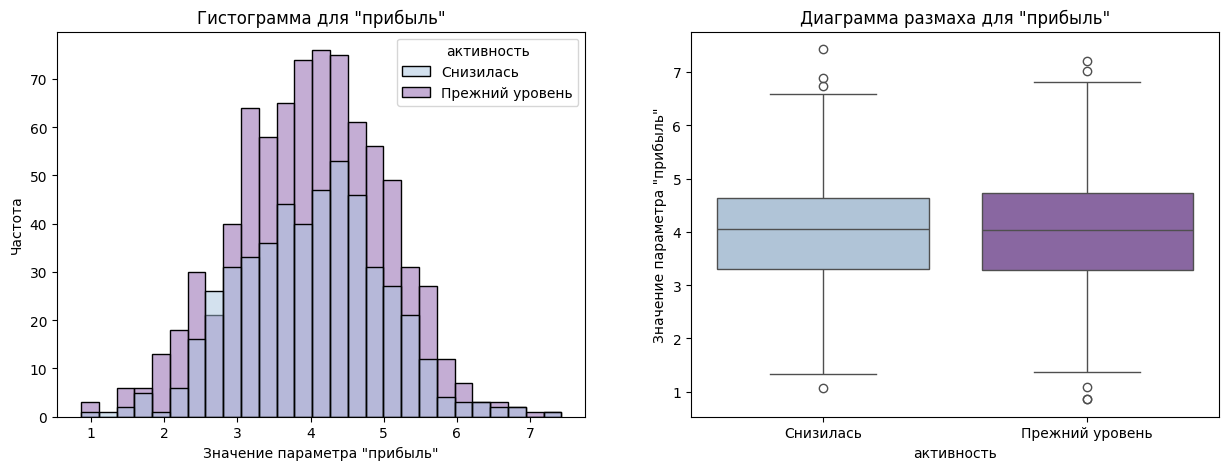

In [69]:
hist_box_graph_1(market, 'прибыль')

Кажется по прибыли никакой разницы нет между теми у кого снизилась активность и у кого нет.

Можно выделить сегмент по категории товаров и провести исследовательский анализ.

In [70]:
market_kids = market.query('категория == "Товары для детей"')
market_kids.head()

,id,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_препред,выручка_пред,выручка_тек,минуты_пред,минуты_тек,выручка_пред_тек,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,10187.6,4.16
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,12768.4,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,11680.0,4.21
6,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,4749.0,3263.0,3772.6,12,10,7035.6,5.26
12,215363,Снизилась,стандарт,нет,4.9,4,923,0.29,Товары для детей,6,0,3,1,4633.0,6010.0,6128.3,8,5,12138.3,1.83


In [71]:
num_df = ['категорий_за_визит',
          'акции', 
          'неоплачено_штук', 
          'страницы', 
          'минуты_пред', 
          'минуты_тек', 
          'выручка_препред',
          'выручка_пред',
          'выручка_тек',
          'прибыль']

cat_df = ['сервис', 'рассылка', 'категория']

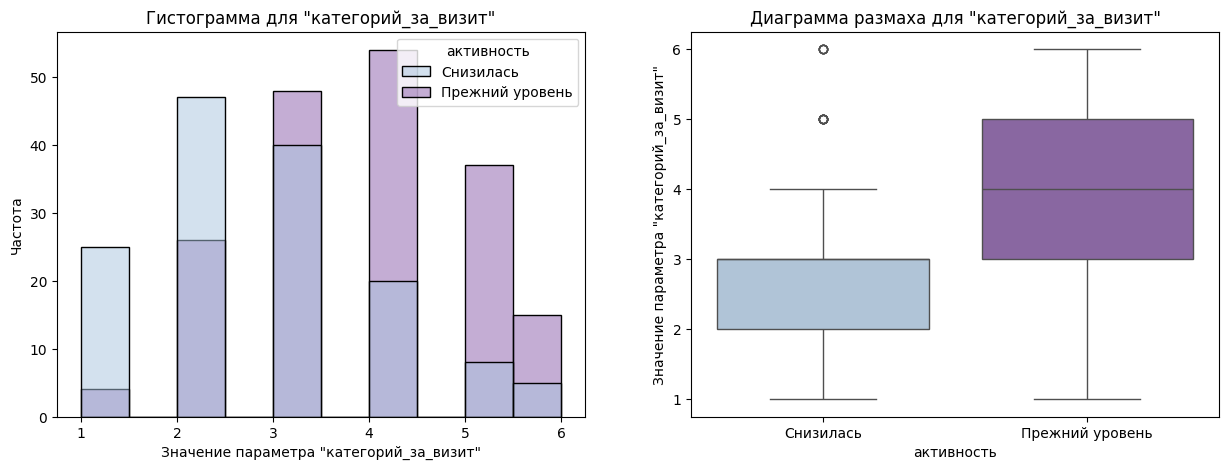

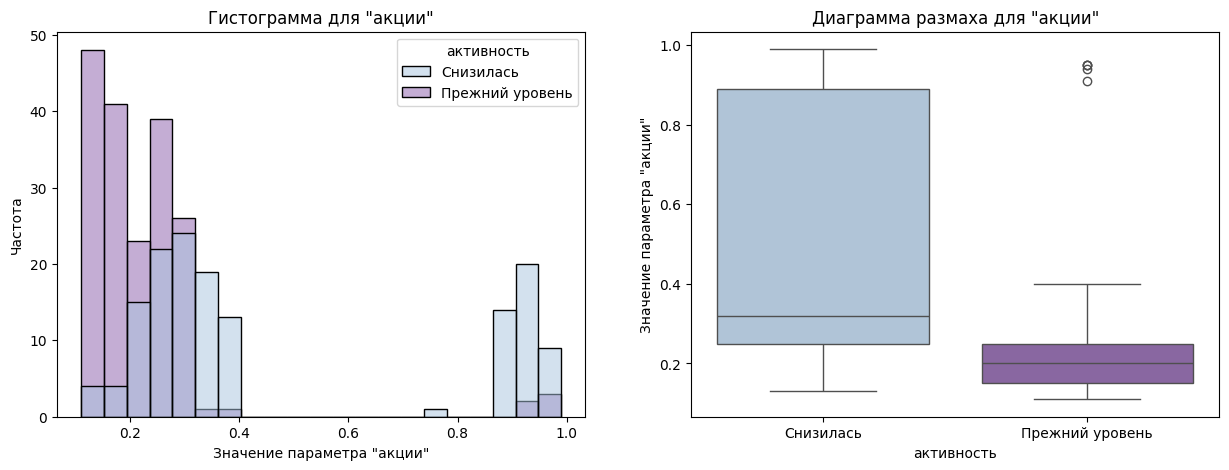

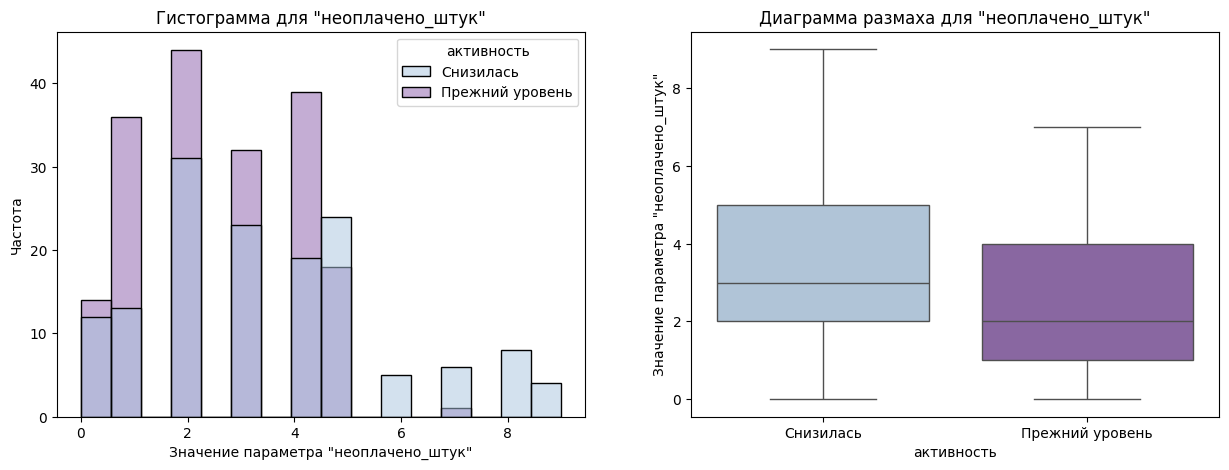

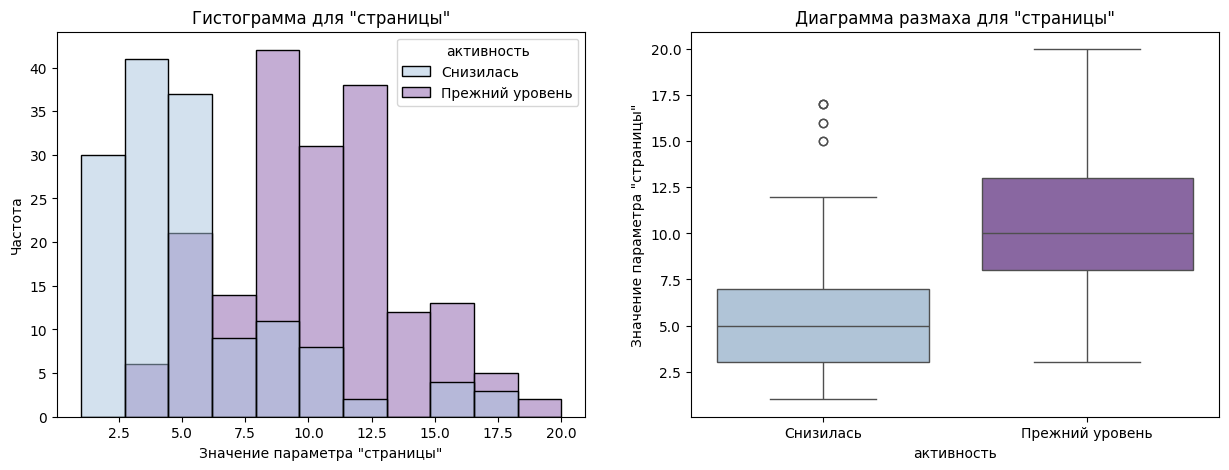

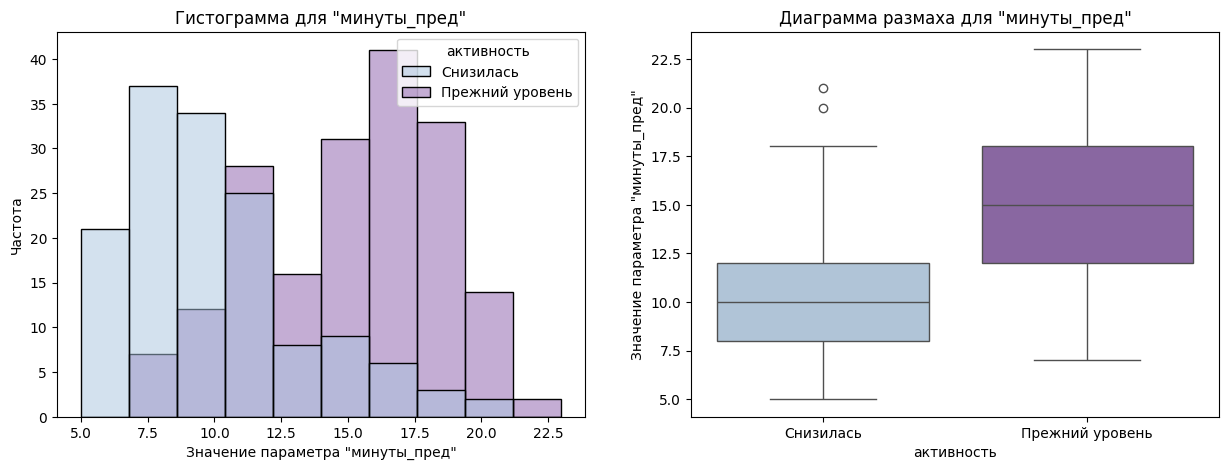

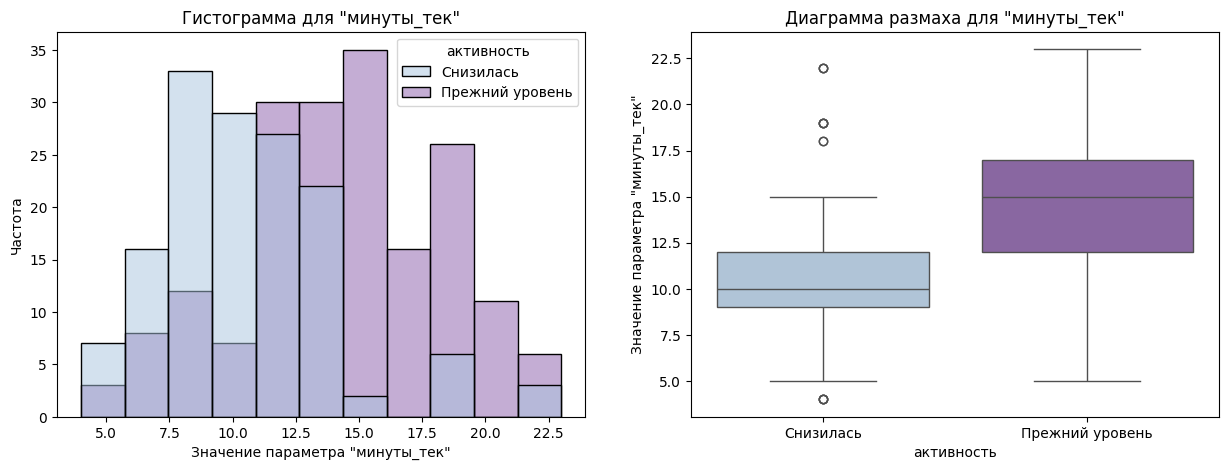

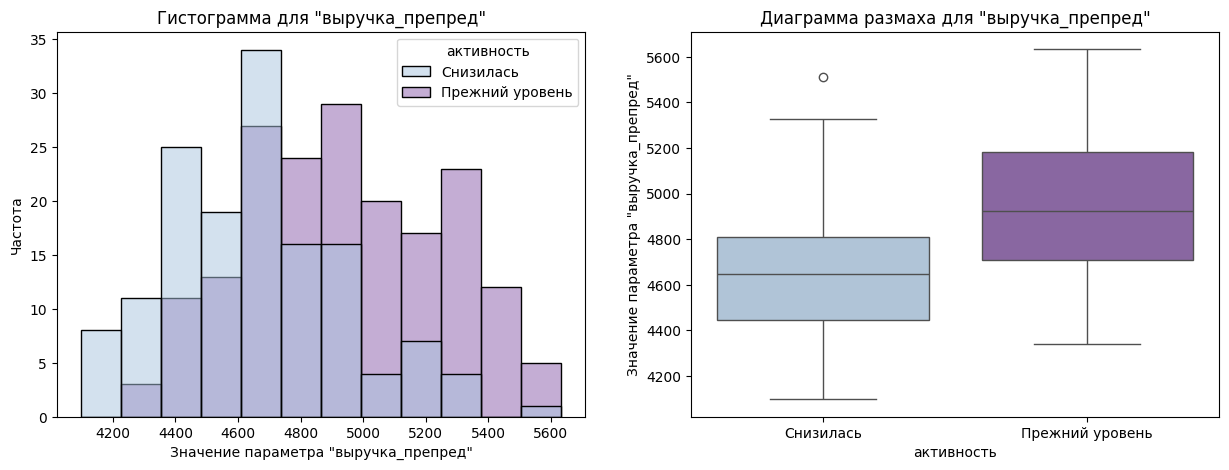

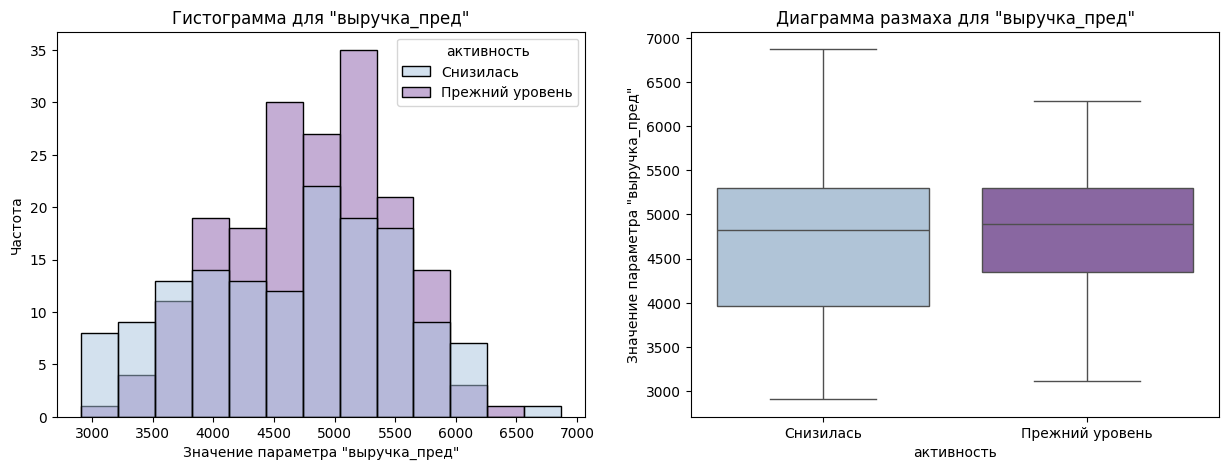

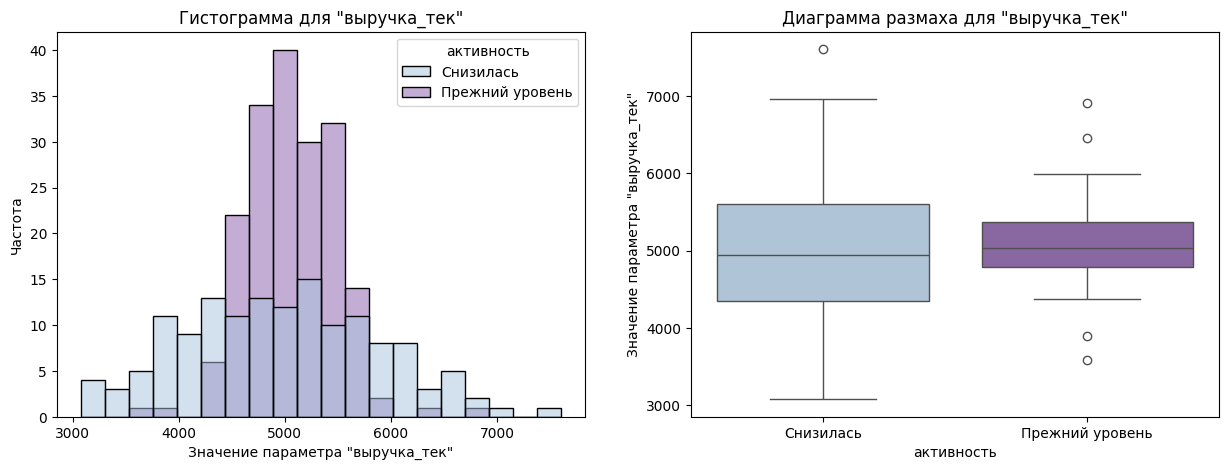

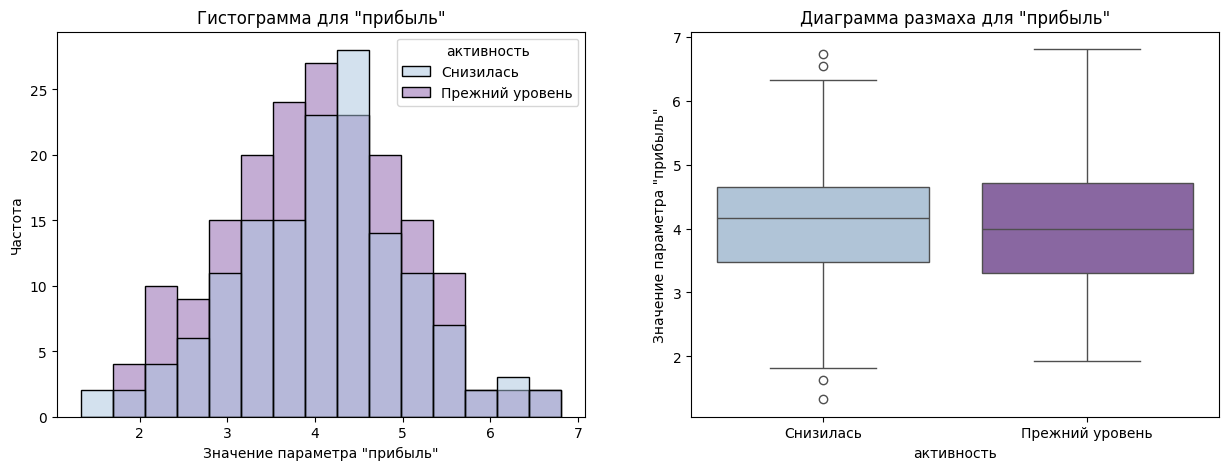

In [72]:
for name in num_df:
    hist_box_graph_1(market_kids, name)

Покупатели, у которых категория "Товары для детей" и у которых снизилась покупательская активность, в основном покупают по акции, практически не рассматривают другие категори за визит, просматривают мало страниц и проводят меньше времени на сайте, чем покупатели, у которых активность осталась на прежнем уровне. 

С точки зрения выручки по месяцам, то 2 месяца назад с покупателей со сниженной активностью выручка была меньше, чем с покупателей с прежним уровнем. А в предыдущий и этот месяц у них выручка примерно на одинаковом уровне. И прибыль на самом деле тоже. 

Может стоит провести акции на деские товары, причем где-нибудь на первых страницах сайта, чтобы они сразу увидели.

# Общий вывод

В данном проекте были проанализированы данные о покупателях интернет-магазина "В один клик" с целью прогнозирования покупательской активности в следующие 3 месяца. 

**Предварительно данные были подготовлены:**
* поиск и замена пропусков;
* поиск явных дубликатов;
* изменение названия столбцов.

Был проведен поиск лучшей модели МО. Ею стала модель SVC - "метод опорных векторов" со значением метрики roc_auc=0.9118. 

У выбранной модели была проанализирована важность признаков. Наиболее важными стали длительность (с момента регистрации), минуты, категорий за визит, страницы, выручка, ошибки, неоплачено, актив_6_мес.  